# Objective: Exploring Feature Engineering techniques for EEG data

### Techniques explored: DWT, Extracting statistics, Shannon Entropy, Variance Thresholding, Correlation Matrix

## 1. Importing libraries

In [2]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

## 2. Importing EEG data (train.csv) and extracting 10 second segments from all eeg_ids

In [9]:
train = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
print('Train shape', train.shape )
train

Train shape (106800, 15)


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106795,351917269,6,12.0,2147388374,6,12.0,4195677307,10351,LRDA,0,0,0,3,0,0
106796,351917269,7,14.0,2147388374,7,14.0,290896675,10351,LRDA,0,0,0,3,0,0
106797,351917269,8,16.0,2147388374,8,16.0,461435451,10351,LRDA,0,0,0,3,0,0
106798,351917269,9,18.0,2147388374,9,18.0,3786213131,10351,LRDA,0,0,0,3,0,0


In [10]:
train.loc[train['eeg_id'] == 351917269]

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
106789,351917269,0,0.0,2147388374,0,0.0,429140316,10351,LRDA,0,0,0,3,0,0
106790,351917269,1,2.0,2147388374,1,2.0,1916299616,10351,LRDA,0,0,0,3,0,0
106791,351917269,2,4.0,2147388374,2,4.0,1085988029,10351,LRDA,0,0,0,3,0,0
106792,351917269,3,6.0,2147388374,3,6.0,3808975447,10351,LRDA,0,0,0,3,0,0
106793,351917269,4,8.0,2147388374,4,8.0,1374115633,10351,LRDA,0,0,0,3,0,0
106794,351917269,5,10.0,2147388374,5,10.0,223739845,10351,LRDA,0,0,0,3,0,0
106795,351917269,6,12.0,2147388374,6,12.0,4195677307,10351,LRDA,0,0,0,3,0,0
106796,351917269,7,14.0,2147388374,7,14.0,290896675,10351,LRDA,0,0,0,3,0,0
106797,351917269,8,16.0,2147388374,8,16.0,461435451,10351,LRDA,0,0,0,3,0,0
106798,351917269,9,18.0,2147388374,9,18.0,3786213131,10351,LRDA,0,0,0,3,0,0


This code from Kaggle arranges data sequentially to extract 10 second segments of the eeg train dataset

In [11]:
TARGETS = train.columns[-6:]

train_17k = train.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_id':'first','spectrogram_label_offset_seconds':'min'})
train_17k.columns = ['spec_id','min']

tmp = train.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_label_offset_seconds':'max'})
train_17k['max'] = tmp

tmp = train.groupby('eeg_id')[['patient_id']].agg('first')
train_17k['patient_id'] = tmp

tmp = train.groupby('eeg_id')[TARGETS].agg('sum')
for t in TARGETS:
    train_17k[t] = tmp[t].values
    
y_data = train_17k[TARGETS].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train_17k[TARGETS] = y_data

tmp = train.groupby('eeg_id')[['expert_consensus']].agg('first')
train['target'] = tmp

train_17k = train_17k.reset_index()
print('Train non-overlapp eeg_id shape:', train_17k.shape )
train_17k

Train non-overlapp eeg_id shape: (17089, 11)


,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
17084,4293354003,1188113564,0.0,0.0,16610,0.0,0.000000,0.00,0.000000,0.500000,0.500000
17085,4293843368,1549502620,0.0,0.0,15065,0.0,0.000000,0.00,0.000000,0.500000,0.500000
17086,4294455489,2105480289,0.0,0.0,56,0.0,0.000000,0.00,0.000000,0.000000,1.000000
17087,4294858825,657299228,0.0,12.0,4312,0.0,0.000000,0.00,0.000000,0.066667,0.933333


In [12]:
ids = train.eeg_id.unique()
sample_ids = ids[0:5]
sample_ids

array([1628180742, 2277392603,  722738444,  387987538, 2175806584])

## Creating dataloader for all eeg_ids

Data Loader type 1: removes overlapping EEG segments

In [13]:
# CREATING DATA LOADER FOR SPECIFIC EEG IDS

import pandas as pd

def create_data_loader(eeg_ids, eeg_data_dir, train_data, segment_length=10):
    """
    Create a data loader function to extract 10-second EEG segments for specified EEG IDs.
    
    Args:
    - eeg_ids (list): List of EEG IDs for which segments need to be extracted.
    - eeg_data_dir (str): Directory path where EEG data files are stored.
    - train_data (DataFrame): DataFrame containing training data with EEG labels and offsets.
    - segment_length (int): Length of EEG segments in seconds.
    
    Returns:
    - data_loader (generator): Generator function to yield EEG segments along with target labels.
    """
    def data_loader():
        for eeg_id in eeg_ids:
            # Load EEG data for the current EEG ID
            eeg_data_path = f"{eeg_data_dir}/{eeg_id}.parquet"
            example = pd.read_parquet(eeg_data_path)
            
            # Filter training data for the current EEG ID
            train_eegid = train_data[train_data['eeg_id'] == eeg_id]
            target_labels = train_eegid.iloc[0][['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']]
            #print(target_labels)
            offset_values_list = train_eegid['eeg_label_offset_seconds'].tolist()
            print("Number of offset subsamples for EEG ID", eeg_id, ":", len(offset_values_list))
            
            # Extract 10-second EEG segments along with target labels
            for offset in offset_values_list:
                start_index = int(offset) * 200
                end_index = start_index + (segment_length * 200)
                
                # Extract 10-second segment centered around the offset
                middle_index = (start_index + end_index) // 2
                segment_start = middle_index - (segment_length // 2 * 200)
                segment_end = middle_index + (segment_length // 2 * 200)
                
                # Extract EEG segment
                eeg_segment = example.iloc[segment_start:segment_end].reset_index(drop=True)
                
                # Get target labels
                #target_labels = train_eegid.iloc[0][['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']]
                
                # Yield EEG segment along with target labels
                yield eeg_segment, target_labels, eeg_id
    
    return data_loader

# Example usage:
eeg_ids = sample_ids
eeg_data_dir = "/kaggle/input/hms-harmful-brain-activity-classification/train_eegs"
train_data = train  # Assuming 'train' is your DataFrame containing training data
segment_length = 10  # 10-second EEG segments
loader = create_data_loader(eeg_ids, eeg_data_dir, train_data, segment_length)

Displaying data for first eeg_id as example

In [14]:
for eeg_segment, target_labels, eeg_id in loader():
    
    print(f'EEG ID: {eeg_id}')
    eeg_segment = pd.DataFrame(eeg_segment)
    display(eeg_segment)
    target_labels = pd.DataFrame(target_labels)
    display(target_labels)
    break;
    

Number of offset subsamples for EEG ID 1628180742 : 9
EEG ID: 1628180742


,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-80.519997,-70.540001,-80.110001,-108.750000,-120.330002,-88.620003,-101.750000,-104.489998,-99.129997,-90.389999,-97.040001,-77.989998,-88.830002,-112.120003,-108.110001,-95.949997,-98.360001,-121.730003,-106.449997,7.920000
1,-80.449997,-70.330002,-81.760002,-107.669998,-120.769997,-90.820000,-104.260002,-99.730003,-99.070000,-92.290001,-96.019997,-84.500000,-84.989998,-115.610001,-103.860001,-97.470001,-89.290001,-115.500000,-102.059998,29.219999
2,-80.209999,-75.870003,-82.050003,-106.010002,-117.500000,-87.489998,-99.589996,-96.820000,-119.680000,-99.360001,-91.110001,-99.440002,-104.589996,-127.529999,-113.349998,-95.870003,-96.019997,-123.879997,-105.790001,45.740002
3,-84.709999,-75.339996,-87.480003,-108.970001,-121.410004,-94.750000,-105.370003,-100.279999,-113.839996,-102.059998,-95.040001,-99.230003,-101.220001,-125.769997,-111.889999,-97.459999,-97.180000,-128.940002,-109.889999,83.870003
4,-90.570000,-80.790001,-93.000000,-113.870003,-129.960007,-102.860001,-118.599998,-101.099998,-107.660004,-102.339996,-98.510002,-95.300003,-88.930000,-115.639999,-99.800003,-97.500000,-88.730003,-114.849998,-100.250000,97.769997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-128.380005,-131.750000,-118.970001,-144.710007,-180.110001,-123.870003,-123.559998,-104.480003,-136.330002,-105.360001,-97.790001,-122.050003,-110.720001,-120.050003,-97.239998,-78.070000,-87.870003,-106.139999,-84.919998,19.879999
1996,-130.050003,-135.289993,-125.190002,-149.190002,-181.169998,-129.110001,-128.600006,-109.720001,-133.880005,-111.220001,-106.860001,-121.769997,-111.639999,-131.330002,-103.629997,-80.559998,-95.040001,-111.730003,-87.650002,7.920000
1997,-135.500000,-141.279999,-133.899994,-154.270004,-187.539993,-131.750000,-134.429993,-114.209999,-137.470001,-121.690002,-117.790001,-122.769997,-114.639999,-140.210007,-109.949997,-90.089996,-93.730003,-113.680000,-91.930000,-50.520000
1998,-137.529999,-150.770004,-139.360001,-153.369995,-182.919998,-130.350006,-127.099998,-110.699997,-159.839996,-133.440002,-118.800003,-139.820007,-136.050003,-151.029999,-122.099998,-97.290001,-99.160004,-126.500000,-96.250000,-53.380001


,0
seizure_vote,3
lpd_vote,0
gpd_vote,0
lrda_vote,0
grda_vote,0
other_vote,0


In [15]:
# Using eeg dataframe 1628180742 for following purposes
eeg_1628180742 = eeg_segment

## 3. Visualizing EEG signals

In [17]:
def plot_eeg(df, title):
    fig, axs = plt.subplots(19, 1, figsize=(30, 20), sharex=True)

    for i, ax in enumerate(axs):
        ax.plot(df.iloc[:,i], color="black")
        ax.set_ylabel(df.columns[i], rotation=0)
        ax.set_yticklabels([])
        ax.set_yticks([])
        ax.set_xticks([])
        ax.spines[["top", "bottom", "left", "right"]].set_visible(False)
        
    fig.suptitle(title, fontsize=50, verticalalignment='top')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust the layout to not overlap with the figure title
    plt.show()

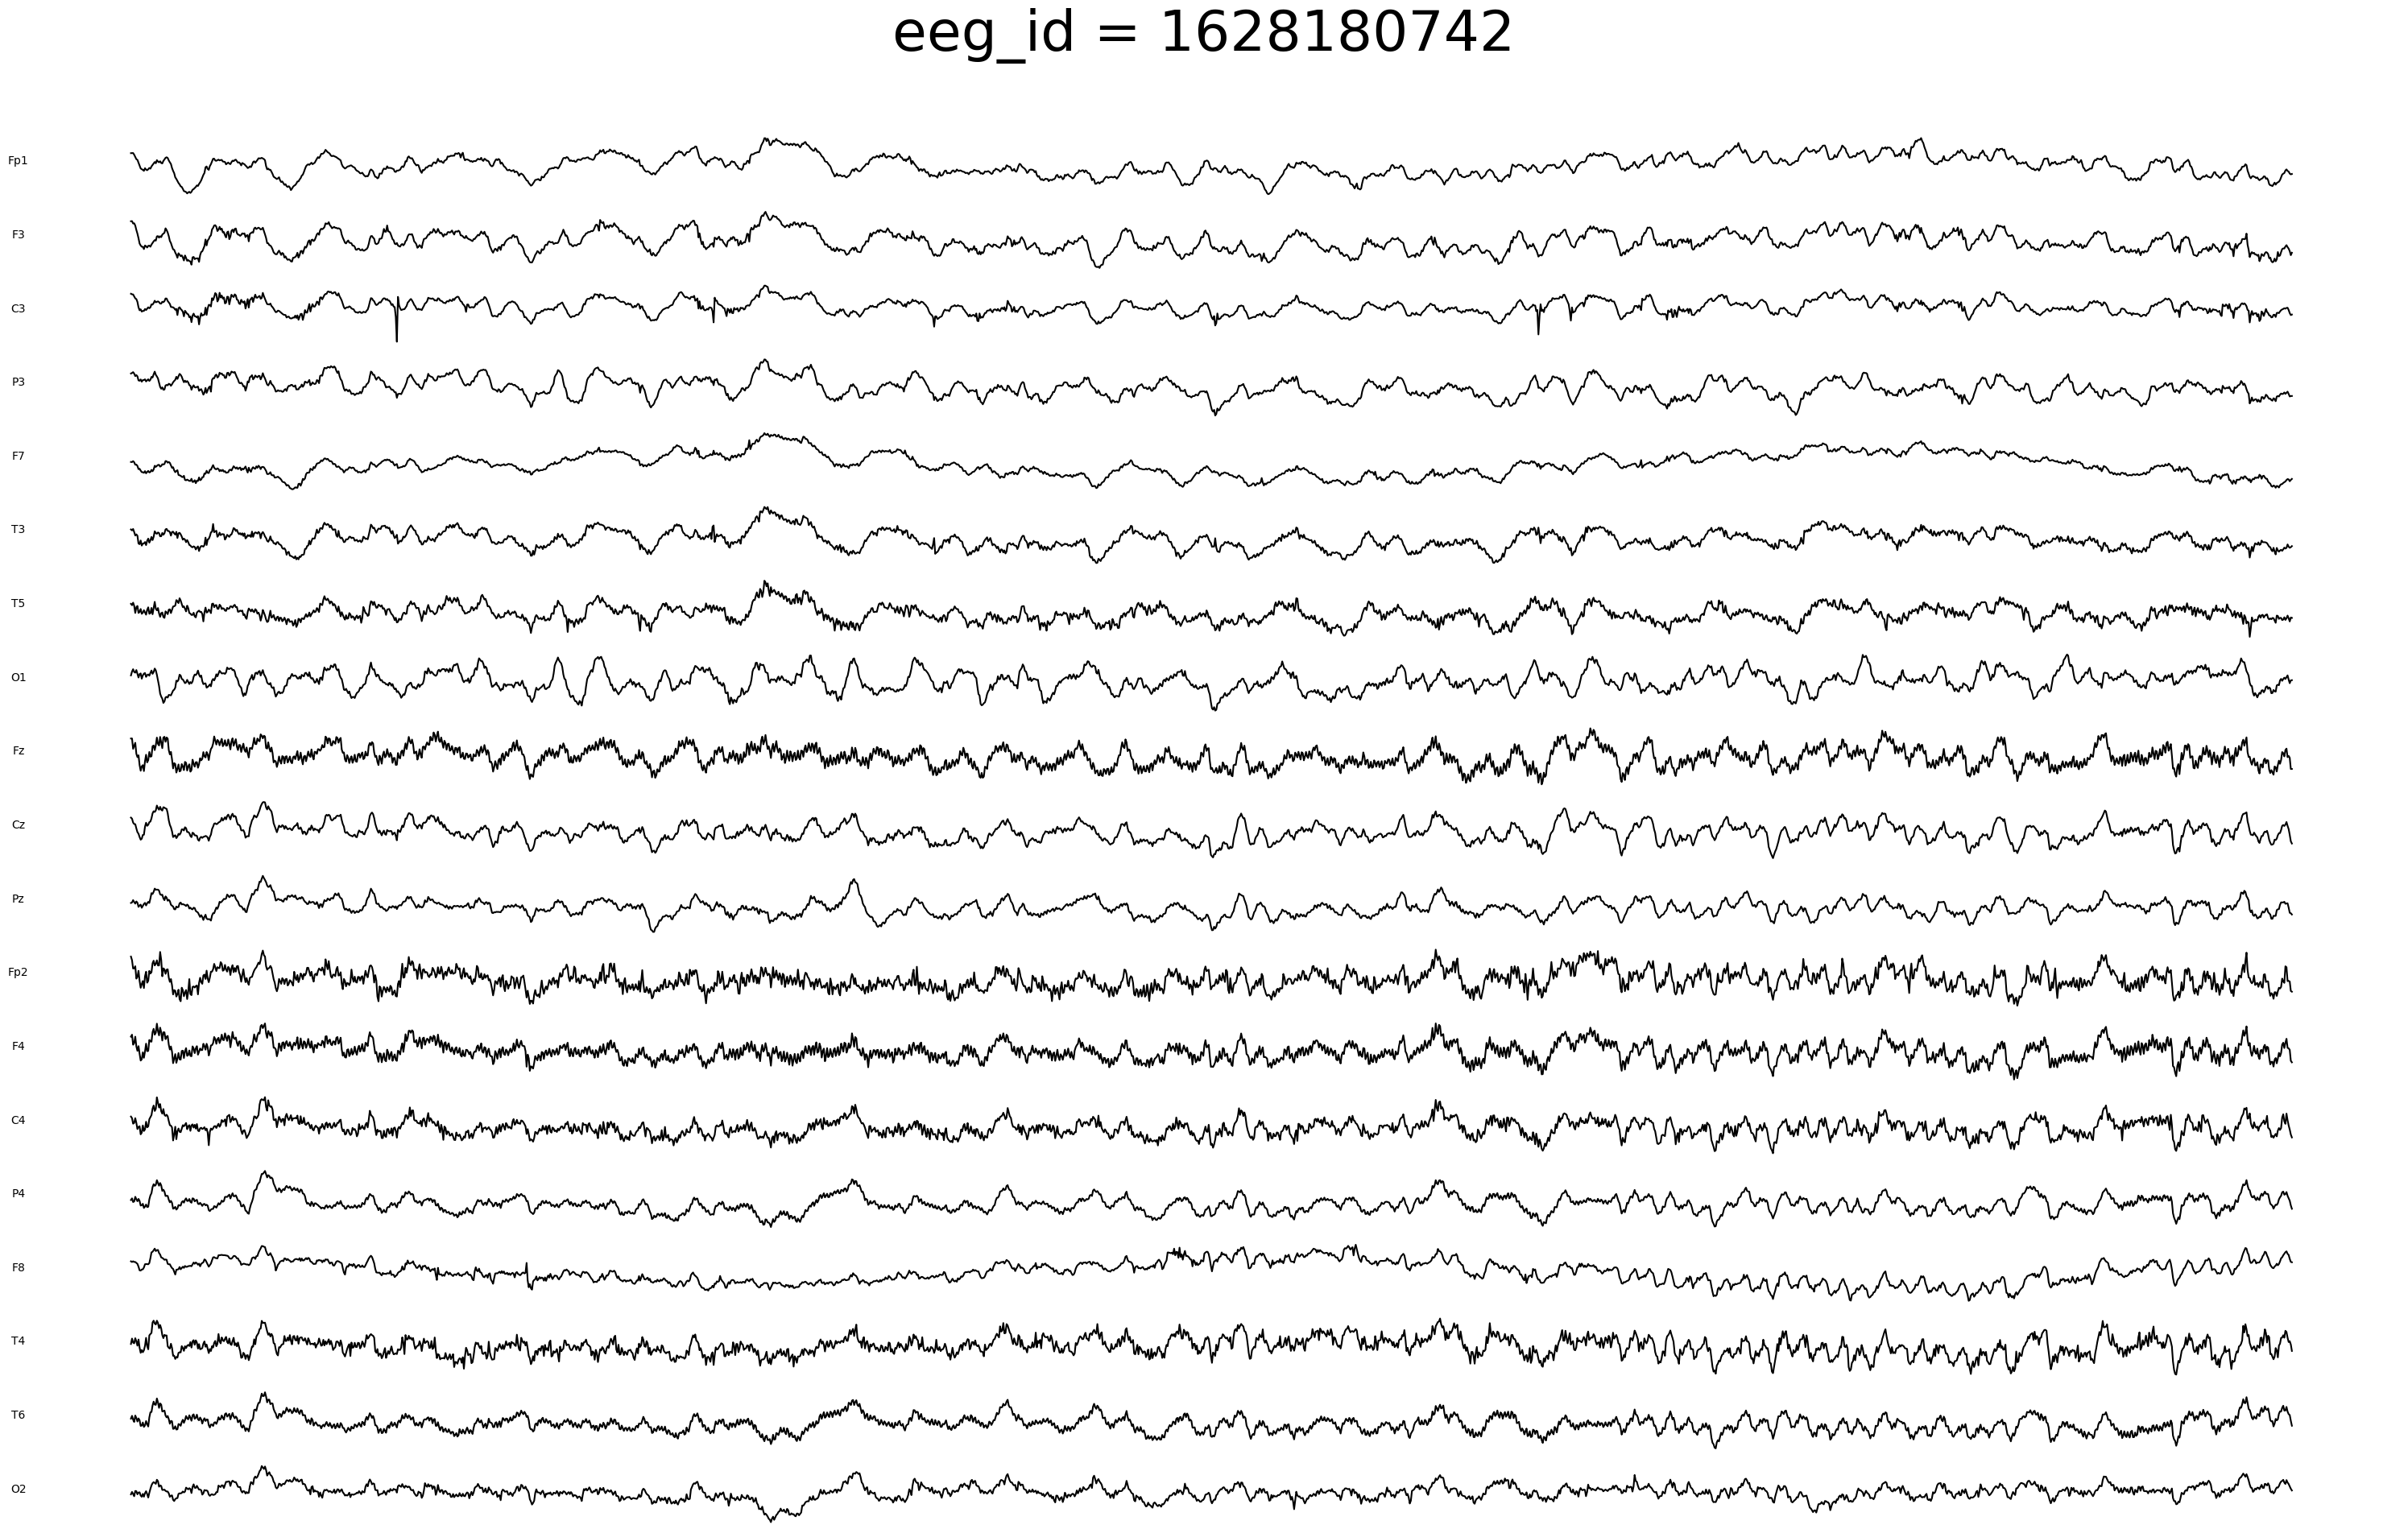

In [18]:
plot_eeg(eeg_1628180742, 'eeg_id = 1628180742')

### Visualizing one channel

Text(0.5, 1.0, 'F3 channel, eeg_id = 2175806584')

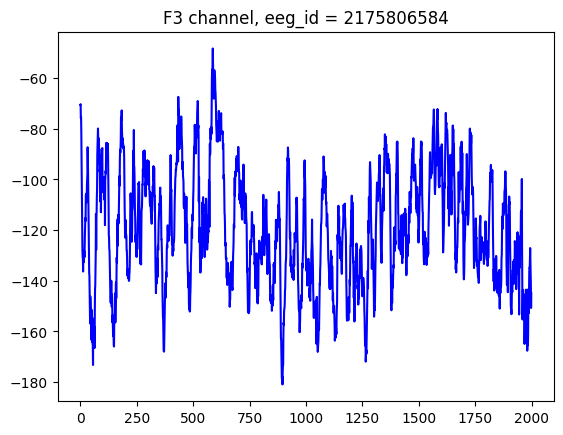

In [19]:
f3 = eeg_1628180742.iloc[:, 1]
plt.plot(f3, color = "blue")
plt.title('F3 channel, eeg_id = 2175806584')

## 4. Preprocessing and Feature Engineering

### 4a. Denoising signals with wavelet transform

In [20]:
# denoising function using wavelet transform
import pywt

def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise(x, wavelet='haar', level=1):
    ret = {key:[] for key in x.columns}
    
    for pos in x.columns:
        coeff = pywt.wavedec(x[pos], wavelet, mode="per")
        sigma = (1/0.6745) * maddest(coeff[-level])

        uthresh = sigma * np.sqrt(2*np.log(len(x)))
        coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

        ret[pos]=pywt.waverec(coeff, wavelet, mode='per')
    
    return pd.DataFrame(ret)

In [21]:
# Denoise entire data
full_eeg_segments_denoised = denoise(eeg_1628180742, wavelet="db8")
full_eeg_segments_denoised

,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-83.843773,-74.950333,-86.803329,-112.380074,-125.007141,-101.417183,-113.424500,-105.805008,-133.097214,-99.410324,-105.145454,-116.682396,-119.394646,-132.618774,-116.698730,-95.002007,-102.656021,-124.530815,-98.713524,79.447334
1,-88.458153,-75.442047,-91.919250,-114.395180,-128.183105,-93.245636,-111.786995,-102.813507,-130.395737,-109.451172,-98.734093,-115.256317,-119.292091,-132.567078,-114.733353,-95.970093,-101.516632,-124.700363,-100.391373,90.823959
2,-74.095757,-76.941284,-78.033073,-102.839958,-113.610085,-89.194695,-110.327568,-100.745148,-127.668373,-95.205818,-94.082336,-113.965492,-119.057037,-132.546265,-112.144234,-97.235497,-100.057030,-124.589455,-102.029037,95.093521
3,-84.287209,-70.991386,-90.312675,-110.215881,-123.907623,-91.152458,-109.070549,-100.407013,-125.815086,-97.899208,-93.067970,-113.048660,-118.902191,-132.819016,-109.801216,-99.387123,-98.912315,-124.812698,-103.748756,89.214851
4,-91.343666,-86.373100,-98.251625,-114.229591,-130.766357,-97.847282,-108.128616,-101.305664,-125.208252,-104.736107,-94.810501,-112.532768,-118.714775,-133.333191,-107.716545,-101.924156,-97.993835,-125.229431,-105.428841,76.540520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-133.936111,-133.158218,-130.341522,-151.842438,-186.982117,-132.264084,-122.908195,-108.731186,-130.056015,-109.331528,-106.879356,-120.303871,-113.736992,-127.625816,-102.017441,-80.132286,-91.731888,-108.103729,-87.382408,41.299847
1996,-135.367477,-136.236298,-134.937622,-153.939163,-186.225784,-129.573486,-121.115631,-109.836571,-132.227737,-115.663322,-110.699265,-119.875519,-115.173553,-128.926575,-106.891876,-83.835594,-95.084930,-112.342918,-89.621140,43.233627
1997,-131.373154,-140.915588,-133.261230,-151.067001,-179.481018,-125.300095,-119.148773,-110.351509,-133.999939,-117.987930,-113.111374,-119.304245,-116.576912,-130.145828,-111.359940,-87.779442,-98.244133,-116.512299,-91.967262,47.387051
1998,-133.510498,-150.454086,-137.205078,-152.104767,-178.692276,-118.929962,-117.145607,-109.882111,-134.888245,-127.611031,-113.104431,-118.592102,-117.828041,-131.217163,-114.747322,-91.290581,-100.748405,-120.133972,-94.328621,55.067337


Text(0.5, 1.0, 'F3 denoised channel, eeg_id = 1628180742')

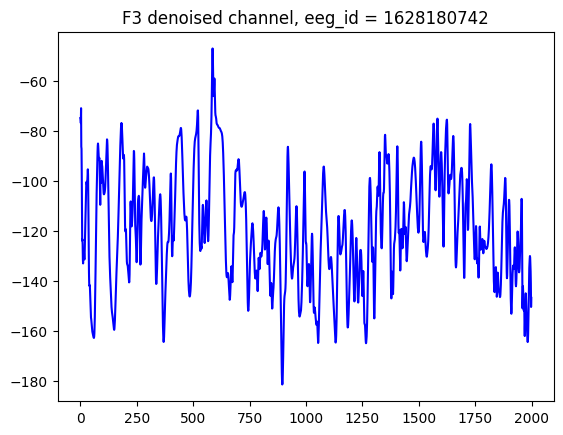

In [22]:
f3_denoise = full_eeg_segments_denoised.iloc[:, 1]
plt.plot(f3_denoise, color = "blue")
plt.title('F3 denoised channel, eeg_id = 1628180742')

### 4b. Discrete Wavelet Transform

In [23]:
from pywt import wavedec

def wavelet_decompose_channels(data, level, output=False):
  # take every x number of points using numpy's slicing (start:stop:step)
    data = data[0::2]

    data.columns.name='channel'

    # transpose the data
    data_t = data.transpose()

    # get the wavelet coefficients at each level in a list
    coeffs_list = wavedec(data_t.values, wavelet='db4', level=level)
    #print(len(coeffs_list))

    # make a list of the component names (later column rows)
    nums = list(range(1,level+1))
    names=[]
    for num in nums:
        names.append('D' + str(num))
    names.append('A' + str(nums[-1]))

  # reverse the names so it counts down
    names = names[::-1]  
    #print(names)

    i = 0
    wavelets = pd.DataFrame()
    for i in range(1, len(coeffs_list)):
    #for i, array in enumerate(coeffs_list):
        #print(i)
        array = coeffs_list[i]
        # turn into a dataframe and transpose
        level_df = pd.DataFrame(array)
        level_df.index = data.columns
        level_df['level'] = names[i]
        level_df= level_df.set_index('level', append=True)
        level_df=level_df.T
        # add the next levels df to another column
        wavelets = pd.concat([wavelets,level_df], axis=1, sort=True)

    # sort values along the channels
    wavelets = wavelets.sort_values(['channel', 'level'], axis=1)

    wavelets_cleaned = wavelets.dropna()

    return wavelets_cleaned

dwt_wavelets = wavelet_decompose_channels(full_eeg_segments_denoised, level=5, output=True)
dwt_wavelets

channel        C3                                                     C4  \
level          D1         D2         D3         D4          D5        D1   
0       -3.215828  -0.169642 -17.444151   1.503160    1.324917 -0.013407   
1       -9.011230  -3.420420 -55.071949   7.658820    5.591689  0.059547   
2       -7.298497 -14.576865  22.210443  29.944637    4.924893 -0.132060   
3       -0.331202  13.461405   9.762214  33.624096  -75.797150 -0.218326   
4       -0.616638   4.205019 -12.429815 -70.046509  102.772034  0.499536   
5        1.222560  -6.676546  -1.613660  22.668037   93.166534  0.810693   
6       -0.449852 -11.724336  -8.251790  20.112782  -38.081818 -0.687669   
7       -1.347358   4.471383  -6.383414 -25.283012   28.421730 -0.966402   
8        2.587717  -5.786166  -5.180565  56.706318  -33.155205  0.488381   
9       -3.491810   2.362256  15.672165  13.389861  112.669998  0.285987   
10       3.096290  -7.844198 -14.988667 -27.111500  -29.020893 -0.187103   
11      -1.585106   3.154249   4.336789  16.811794  -71.743019  0.188229   
12       0.869292 -14.326991  -0.963321  -0.717020   24.737394  0.058263   
13      -0.970313  10.478575   5.014596  58.887459   45.687996  0.089453   
14       0.491276  -8.603518 -22.227365   9.070314  -47.324535 -0.074567   
15       0.197913   5.318146  -6.017267 -57.196651   38.131477 -0.307846   
16       0.266152   0.193676  -5.129673   0.944663   -1.533541  0.063775   
17       2.897404  -2.473731 -54.320515 -44.617298   43.541119  0.009263   
18       6.736622  -0.424096  48.729649  97.398689    4.265113  0.026201   
19      -1.027462   1.732336  15.131000 -23.238005   89.166908  0.226573   
20      -2.116480  -0.573124 -16.984928  18.464577  -38.315948 -0.033625   
21       4.759010  -0.793348  -3.251345 -58.840675  -16.066502  0.001526   
22      -9.646902  -5.763696  41.603226  -3.194103  -50.036823 -0.014132   
23      -7.457385   0.290495 -42.702915   6.262900   20.517288 -0.173011   
24      -0.815618  -0.244446  32.262791  17.251448  -15.439129  0.023015   
25      -0.556274   0.698574 -22.346703  -1.449615   47.867317 -0.007124   
26       0.376710  -4.984905   3.723608  58.301937  -93.605049 -0.176871   
27       0.269217   5.953085 -19.725891   4.384308   72.579979 -0.160308   
28      -0.072685  -8.097830  26.014835 -26.741587  -33.233574  0.448224   
29       0.063124  21.248920 -12.050347   7.887202   32.459133  0.741164   
30      -0.068875 -12.210321  -2.676730 -87.526497  -55.448627 -0.398029   
31      -0.188244  -3.597955  13.530788  75.111671  -50.925377 -0.530335   
32       0.027347 -37.419842 -20.487324  29.003302    7.086879 -0.050040   
33      -0.053365   4.467916   0.865542  61.460106  -30.604759 -0.531400   
34       0.029157 -12.696792 -17.648956  20.742588   14.440714  0.473533   
35       0.166705  -0.969166 -32.961796 -32.412495   -7.388797  0.959179   
36      -0.063110  -3.399383   1.578212  17.994314   28.560257 -0.536751   
37      -0.027974   1.411545   4.888703 -20.059774    0.778112 -0.390413   

channel                                              ...        T5            \
level           D2         D3         D4         D5  ...        D1        D2   
0        -0.039773  -2.075919   0.092831  -0.035691  ...  0.209365 -1.501886   
1        -0.406199  -6.471498   0.756266  -1.376071  ...  0.331804 -4.481738   
2        -0.543128   6.827668  -6.399116 -30.827152  ... -0.417614  4.052550   
3        -2.386855  30.353483  46.873375 -32.884342  ... -0.389498 -5.597783   
4        10.831383 -35.643547  -0.501479  41.135422  ...  0.361860  6.909962   
5       -13.831324  24.316378  39.002106 -54.703701  ...  0.510302 -6.712195   
6         5.578060 -18.577410  70.046280  18.256729  ... -0.424793  4.540879   
7         0.805334  17.987591 -15.963522 -75.312531  ... -0.421312  0.851794   
8         1.500924 -10.332251  39.460968  -1.539636  ...  0.311076 -6.614805   
9        -3.531134  23.025444  22.474850   4.563184  ...  0.230386  7.399106   

### 4c. Mean Absolute Value

In [24]:
def MAV(data):
    # Initialize an empty DataFrame to store the means for each channel
    means = pd.DataFrame(index=data.index)

    # Iterate over each channel and calculate the mean across 'D1' to 'D5'
    for channel in data.columns.get_level_values(0).unique():
    # Calculate the mean for the current channel
        means[channel] = data[channel].abs().mean(axis=1)
    
    means.columns = [f"{col}_DT_MAV" for col in means.columns]
    
    return means


# Use the function with your data
example_wavelet_mean = MAV(dwt_wavelets)
example_wavelet_mean

,C3_DT_MAV,C4_DT_MAV,Cz_DT_MAV,EKG_DT_MAV,F3_DT_MAV,F4_DT_MAV,F7_DT_MAV,F8_DT_MAV,Fp1_DT_MAV,Fp2_DT_MAV,Fz_DT_MAV,O1_DT_MAV,O2_DT_MAV,P3_DT_MAV,P4_DT_MAV,Pz_DT_MAV,T3_DT_MAV,T4_DT_MAV,T5_DT_MAV,T6_DT_MAV
0,4.731540,0.451524,3.763143,5.070055,4.699119,0.353352,3.950618,1.819701,4.423001,0.408030,2.421035,0.560307,1.375445,2.094294,1.350469,1.361743,4.042035,0.651738,0.739275,0.563336
1,16.150822,1.813916,11.828537,20.744953,15.677771,1.417413,13.359456,5.449103,15.038399,1.536672,7.764369,1.582225,4.170412,6.991305,4.117851,4.116532,12.870051,2.190137,2.177218,2.141660
2,15.791067,8.945826,12.428933,130.010574,22.853081,11.077225,13.813929,7.150108,15.942530,7.043597,8.953936,4.303254,3.739580,6.696408,9.574553,6.720302,10.486448,8.014757,4.215267,7.817665
3,26.595215,22.543278,30.037823,372.804932,40.923119,18.549570,27.323261,23.745228,50.125935,31.740656,34.209946,17.879375,8.107450,15.342928,24.294617,15.596434,14.353595,20.083874,5.542984,20.757715
4,38.014000,17.722273,26.378582,275.974915,34.166058,10.604108,40.731552,12.279739,39.919712,16.619541,26.073578,8.778048,12.938963,19.238386,22.979046,27.054455,32.215527,13.031715,9.269398,17.257727
5,25.069468,26.532841,15.340858,182.123611,32.399513,13.054384,29.896179,9.733659,37.669533,14.256601,17.757797,12.279619,17.849323,24.782446,43.503113,22.945183,25.255711,13.766428,18.172466,25.548615
6,15.724115,22.629230,23.042255,139.655273,11.491980,16.211159,17.395031,15.750834,21.667269,16.252781,14.090509,9.375933,15.661263,10.878718,29.026373,17.591969,6.219818,17.296543,4.816539,22.883827
7,13.181379,22.207075,17.541824,122.669235,13.226366,10.763303,24.129688,9.486691,14.996234,5.284811,11.395905,13.774518,7.211558,10.839993,25.952978,6.622676,22.127918,14.441620,8.587945,18.159687
8,20.683193,10.664432,15.510172,68.513687,21.116947,10.541021,22.901737,5.876182,31.816864,16.599306,14.165741,17.647640,5.609702,23.169743,9.846567,18.803146,17.068554,3.629565,12.099432,10.095197
9,29.517218,10.776119,22.207575,255.576996,31.950129,12.351455,27.871313,11.273436,30.667877,19.664417,24.563236,24.830509,12.868350,33.375832,14.245939,25.574192,30.267643,9.522729,23.871876,13.071333


### 4d. Mean Average Power

In [25]:
def MAVP(data):
    # Initialize an empty DataFrame to store the means for each channel
    means_abs = pd.DataFrame(index=data.index)

    # Iterate over each channel and calculate the mean across 'D1' to 'D5'
    for channel in data.columns.get_level_values(0).unique():
    # Calculate the mean for the current channel
        means_abs[channel] = (data[channel]**2).mean(axis = 1)
    
    means_abs.columns = [f"{col}_DT_MAVP" for col in means_abs.columns]
    
    return means_abs

example_wavelet_meanabs = MAVP(dwt_wavelets)
example_wavelet_meanabs

,C3_DT_MAVP,C4_DT_MAVP,Cz_DT_MAVP,EKG_DT_MAVP,F3_DT_MAVP,F4_DT_MAVP,F7_DT_MAVP,F8_DT_MAVP,Fp1_DT_MAVP,Fp2_DT_MAVP,Fz_DT_MAVP,O1_DT_MAVP,O2_DT_MAVP,P3_DT_MAVP,P4_DT_MAVP,Pz_DT_MAVP,T3_DT_MAVP,T4_DT_MAVP,T5_DT_MAVP,T6_DT_MAVP
0,63.736725,0.864219,40.301056,34.522392,77.746071,0.465474,37.195145,8.767054,52.534588,0.385452,11.468611,0.548146,4.305185,8.421915,2.744187,3.275106,35.171913,0.673146,0.908964,1.260268
1,643.149170,8.902866,410.332428,648.161987,783.231018,4.842329,376.902588,86.902184,528.588440,4.385755,115.136925,5.357572,42.776466,85.510750,28.504848,34.594650,361.001648,7.615217,8.862185,12.516122
2,335.998535,207.638275,274.874756,27092.964844,720.455444,272.511658,295.279083,111.066833,428.490479,104.894821,116.590286,32.153656,25.398403,48.152470,172.223068,105.141090,159.832565,124.127365,23.887964,152.374512
3,1430.481567,841.114380,1416.715088,281749.375000,3861.468750,624.700989,1590.035522,953.211426,6323.478027,2079.553223,1930.640259,533.151978,97.194290,368.332916,998.097656,417.944427,331.339203,619.629272,51.438354,727.271545
4,3128.233154,616.081055,1192.710205,79379.546875,3020.518799,274.159119,3599.159424,271.904938,3530.890625,417.629395,1128.818115,126.109634,282.325928,576.451904,818.572266,1574.391113,2128.067139,276.973053,159.191742,452.894714
5,1848.503540,1059.381592,492.409424,87682.484375,3902.214111,296.806732,3452.309814,131.538345,4770.571289,358.880920,755.463806,343.812256,617.060974,1293.847412,3690.345703,891.332214,1818.389282,246.290436,957.722656,1180.379639
6,412.100677,1123.299561,840.765747,36714.972656,178.916183,497.007233,385.138367,464.274506,670.552429,523.925415,269.536865,145.047348,477.299713,199.999435,1869.765869,665.904419,65.990456,727.380371,55.982628,1157.045166
7,301.916412,1250.389404,602.047241,20150.902344,294.021912,267.728912,1082.333252,176.592484,513.963257,54.072357,230.681793,363.435364,107.659035,241.929108,1915.803955,102.825050,955.755249,605.677185,180.614120,1118.989624
8,876.377625,333.757019,678.783081,5064.655273,995.922485,270.472046,1570.718384,75.251282,3531.470215,911.022583,291.142395,458.017517,54.626556,974.604309,270.165100,703.104614,780.304565,22.732655,327.887421,217.950516
9,2627.441162,213.732666,792.242310,132353.734375,2845.038574,308.725677,2891.259277,370.480499,2480.469238,684.604614,1224.581421,970.587097,269.977173,2130.559814,467.773438,1084.784546,3125.240967,172.766098,1344.218750,275.106689


### 4e. Standard Deviation (STD)

In [26]:
def std_val(data):
    # Initialize an empty DataFrame to store the means for each channel
    std_vals = pd.DataFrame(index=data.index)

    # Iterate over each channel and calculate the mean across 'D1' to 'D5'
    for channel in data.columns.get_level_values(0).unique():
    # Calculate the mean for the current channel
        std_vals[channel] = data[channel].std(axis = 1)
    
    std_vals.columns = [f"{col}_DT_STD" for col in std_vals.columns]
    
    return std_vals

example_wavelet_std = std_val(dwt_wavelets)
example_wavelet_std

,C3_DT_STD,C4_DT_STD,Cz_DT_STD,EKG_DT_STD,F3_DT_STD,F4_DT_STD,F7_DT_STD,F8_DT_STD,Fp1_DT_STD,Fp2_DT_STD,Fz_DT_STD,O1_DT_STD,O2_DT_STD,P3_DT_STD,P4_DT_STD,Pz_DT_STD,T3_DT_STD,T4_DT_STD,T5_DT_STD,T6_DT_STD
0,7.966689,0.930389,6.509746,5.751017,9.185941,0.699324,5.887292,3.145876,7.130939,0.615321,3.353447,0.712071,2.266826,2.609658,1.846671,1.599698,5.701412,0.911185,1.060234,1.124928
1,25.627457,2.891786,20.972443,27.685972,29.395363,2.409956,19.145809,9.882998,23.006481,2.083823,10.603590,2.351280,7.120746,8.514380,5.954299,5.516984,18.948404,3.044250,3.326583,3.470593
2,18.921679,14.535090,16.646900,173.895874,25.535042,13.724824,17.892160,11.084198,21.020454,11.048119,12.071140,6.160253,4.862703,7.430745,14.655194,10.276980,13.664280,11.613840,3.061836,13.109635
3,42.065601,31.053062,41.001553,592.805359,68.315056,27.937456,44.548077,34.260338,87.466667,50.321362,49.074409,23.411255,9.714977,19.945467,33.995689,22.468941,19.590721,27.492144,6.561914,27.999960
4,62.303848,27.509672,38.610355,313.477295,60.253853,18.468054,64.150383,18.435436,63.313496,22.715427,37.347290,12.437545,17.718204,26.793100,31.515207,42.901600,51.489727,18.603201,13.209953,23.678556
5,41.462238,36.376591,17.925800,292.491058,63.765503,13.814710,59.729771,12.759769,72.477654,20.486908,23.455395,18.916061,27.606153,34.807156,66.652733,32.812523,42.548531,17.520639,32.139576,37.462238
6,21.009926,33.552155,32.405514,214.111740,14.632022,24.924185,17.438133,24.035280,28.905130,25.581463,17.813332,13.167248,21.870350,14.191302,41.619377,26.401951,6.698034,28.865589,8.152771,33.881393
7,19.426651,35.961716,25.883694,151.981995,19.139193,18.147242,36.781151,14.783527,24.644526,8.116081,16.134428,16.327087,11.488037,13.843959,43.494156,11.179387,34.449684,26.283796,14.627379,34.759598
8,32.923584,19.324913,27.934734,21.521202,35.039383,18.384804,41.057610,8.184106,61.327690,28.723276,18.589373,23.348101,8.218572,34.764668,15.674973,29.634619,29.817135,5.329375,19.494326,13.882103
9,47.915016,12.552610,21.131149,342.258789,52.759304,15.104245,53.064770,18.190952,51.221661,19.832739,28.237082,21.950405,12.645647,36.659523,19.274397,24.453325,52.548916,11.432851,31.111738,16.980656


### 4f. Variance

In [28]:
def var_val(data):
    # Initialize an empty DataFrame to store the means for each channel
    var = pd.DataFrame(index=data.index)

    # Iterate over each channel and calculate the mean across 'D1' to 'D5'
    for channel in data.columns.get_level_values(0).unique():
    # Calculate the mean for the current channel
        var[channel] = data[channel].var(axis = 1)
    
    var.columns = [f"{col}_DT_VAR" for col in var.columns]
    
    return var

example_wavelet_var = var_val(dwt_wavelets)
example_wavelet_var

,C3_DT_VAR,C4_DT_VAR,Cz_DT_VAR,EKG_DT_VAR,F3_DT_VAR,F4_DT_VAR,F7_DT_VAR,F8_DT_VAR,Fp1_DT_VAR,Fp2_DT_VAR,Fz_DT_VAR,O1_DT_VAR,O2_DT_VAR,P3_DT_VAR,P4_DT_VAR,Pz_DT_VAR,T3_DT_VAR,T4_DT_VAR,T5_DT_VAR,T6_DT_VAR
0,63.468128,0.865623,42.376793,33.074192,84.381508,0.489053,34.660213,9.896537,50.850285,0.378620,11.245607,0.507045,5.138501,6.810315,3.410195,2.559032,32.506096,0.830259,1.124095,1.265464
1,656.766541,8.362425,439.843353,766.513062,864.087341,5.807889,366.561981,97.673653,529.298157,4.342319,112.436127,5.528517,50.705017,72.494667,35.453678,30.437119,359.042053,9.267456,11.066157,12.045015
2,358.029938,211.268845,277.119263,30239.777344,652.038391,188.370789,320.129395,122.859451,441.859467,122.060928,145.712433,37.948715,23.645884,55.215973,214.774719,105.616318,186.712555,134.881271,9.374841,171.862534
3,1769.514771,964.292725,1681.127441,351418.187500,4666.947266,780.501404,1984.531250,1173.770630,7650.417480,2532.239258,2408.297852,548.086853,94.380791,397.821686,1155.706787,504.853271,383.796387,755.817932,43.058716,783.997803
4,3881.769287,756.782043,1490.759399,98268.023438,3630.526855,341.069000,4115.271484,339.865326,4008.598633,515.990601,1394.820068,154.692520,313.934784,717.870239,993.208313,1840.547241,2651.192139,346.079102,174.502869,560.674072
5,1719.117310,1323.256470,321.334351,85551.015625,4066.039307,190.846191,3567.645508,162.811722,5253.009766,419.713409,550.155579,357.817413,762.099731,1211.538208,4442.586914,1076.661621,1810.377563,306.972809,1032.952393,1403.419312
6,441.416962,1125.747070,1050.117432,45843.839844,214.096054,621.215027,304.088470,577.694702,835.506531,654.411255,317.314758,173.376404,478.312195,201.393066,1732.172485,697.062988,44.863659,833.222290,66.467674,1147.948853
7,377.394775,1293.245117,669.965637,23098.527344,366.308685,329.322357,1352.853027,218.552673,607.352600,65.870773,260.319794,266.573792,131.975006,191.655197,1891.741577,124.978699,1186.780640,690.837952,213.960236,1208.229614
8,1083.962402,373.452240,780.349426,463.162140,1227.758423,338.000977,1685.727173,66.979591,3761.085449,825.026611,345.564789,545.133789,67.544914,1208.582031,245.704758,878.210632,889.061523,28.402235,380.028748,192.712784
9,2295.848877,157.568024,446.525482,117141.085938,2783.544189,228.138214,2815.869873,330.910767,2623.658691,393.337555,797.332825,481.820282,159.912384,1343.920654,371.502380,597.965088,2761.388428,130.710068,967.940247,288.342682


### 4g. Ratio channels

In [29]:
def ratio_channels(epoch_data):
    # Initialize an empty DataFrame to store the ratio values for each pair of channels
    ratio_data = pd.DataFrame(index=epoch_data.index)
    
    # Iterate over each pair of adjacent channels
    for i in range(len(epoch_data.columns) - 1):
        channel1 = epoch_data.columns[i]
        channel2 = epoch_data.columns[i + 1]
        
       # Calculate the ratio between the values of the two channels
        ratio_data[f"{channel1}-{channel2}_Ratio"] = epoch_data[channel1] / epoch_data[channel2]
    
    return ratio_data

# Example usage:
example_ratio_data = ratio_channels(dwt_wavelets)
example_ratio_data

,"('C3', 'D1')-('C3', 'D2')_Ratio","('C3', 'D2')-('C3', 'D3')_Ratio","('C3', 'D3')-('C3', 'D4')_Ratio","('C3', 'D4')-('C3', 'D5')_Ratio","('C3', 'D5')-('C4', 'D1')_Ratio","('C4', 'D1')-('C4', 'D2')_Ratio","('C4', 'D2')-('C4', 'D3')_Ratio","('C4', 'D3')-('C4', 'D4')_Ratio","('C4', 'D4')-('C4', 'D5')_Ratio","('C4', 'D5')-('Cz', 'D1')_Ratio",...,"('T4', 'D5')-('T5', 'D1')_Ratio","('T5', 'D1')-('T5', 'D2')_Ratio","('T5', 'D2')-('T5', 'D3')_Ratio","('T5', 'D3')-('T5', 'D4')_Ratio","('T5', 'D4')-('T5', 'D5')_Ratio","('T5', 'D5')-('T6', 'D1')_Ratio","('T6', 'D1')-('T6', 'D2')_Ratio","('T6', 'D2')-('T6', 'D3')_Ratio","('T6', 'D3')-('T6', 'D4')_Ratio","('T6', 'D4')-('T6', 'D5')_Ratio"
0,18.956509,0.009725,-11.604986,1.134531,-98.826378,0.337074,0.019159,-22.362259,-2.600990,0.022402,...,-2.183011,-0.139401,-1.078354,-33.857964,0.074624,-6.771023,-0.885360,0.036703,-30.478172,-1.471766
1,2.634539,0.062108,-7.190657,1.369679,93.903679,-0.146596,0.062767,-8.557175,-0.549583,1.852691,...,-7.731344,-0.074035,-0.941530,43.025974,-0.092051,-7.837338,-0.275324,0.072157,-8.056857,-0.725382
2,0.500690,-0.656307,0.741717,6.080261,-37.292732,0.243148,-0.079548,-1.066970,0.207581,-25.517225,...,54.616913,-0.103050,0.750588,1.651248,0.411949,-63.640121,-0.285139,0.046229,-2.818399,0.130589
3,-0.024604,1.378929,0.290334,-0.443606,347.173828,0.091470,-0.078635,0.647563,-1.425401,-18.185902,...,89.979576,0.069581,-1.575815,-0.254058,3.334641,15.544938,0.083314,-0.105684,0.662104,-1.979175
4,-0.146643,-0.338301,0.177451,-0.681572,205.734924,0.046119,-0.303881,71.076828,-0.012191,-13.348793,...,22.526741,0.052368,-0.785572,0.345726,-5.260298,8.554657,0.048281,-0.308762,-2.765475,0.613027
5,-0.183113,4.137517,-0.071187,0.243307,114.922089,-0.058613,-0.568807,0.623463,-0.712970,-18.079582,...,-38.493687,-0.076026,0.666832,-1.772438,0.083645,79.993134,-0.058685,-0.540345,1.549362,-0.252607
6,0.038369,1.420823,-0.410276,-0.528147,55.378101,-0.123281,-0.300260,-0.265216,3.836738,-8.490033,...,18.913477,-0.093549,16.356310,0.091528,-0.191900,22.350849,-0.129946,-0.304393,-0.251183,3.704685
7,-0.301329,-0.700469,0.252478,-0.889566,-29.409847,-1.200002,0.044772,-1.126793,0.211964,-89.720261,...,126.810989,-0.494618,-0.200615,0.465609,-0.322210,-27.737810,-0.752771,0.102835,-7.982297,0.022438
8,-0.447225,1.116899,-0.091358,-1.710329,-67.888000,0.325387,-0.145266,-0.261835,-25.630060,-1.818554,...,-4.613488,-0.047027,133.115051,-0.002804,-0.495146,-72.903763,0.352984,-0.263837,-0.380132,0.470932
9,-1.478167,0.150729,1.170450,0.118841,393.969086,-0.080990,-0.153358,1.024498,4.925256,-1.351658,...,13.789121,0.031137,1.669121,0.136190,0.435462,267.966095,-0.076980,-0.158075,0.876919,-2.109761


### 4h. Shannon Entropy

In [30]:
from scipy.stats import entropy

def shannon_entropy(data):
    # Initialize an empty DataFrame to store the entropy values for each channel
    entropy_df = pd.DataFrame(index=data.index)

    # Iterate over each channel and calculate the entropy across 'D1' to 'D5'
    for channel in data.columns.get_level_values(0).unique():
        # Calculate the entropy for the current channel
        entropy_values = data[channel].apply(lambda x: entropy(x.abs(), base=2), axis=1)
        entropy_df[channel + '_entropy'] = entropy_values

    return entropy_df

# Example usage:
example_wavelet_entropy = shannon_entropy(dwt_wavelets)
example_wavelet_entropy

,C3_entropy,C4_entropy,Cz_entropy,EKG_entropy,F3_entropy,F4_entropy,F7_entropy,F8_entropy,Fp1_entropy,Fp2_entropy,Fz_entropy,O1_entropy,O2_entropy,P3_entropy,P4_entropy,Pz_entropy,T3_entropy,T4_entropy,T5_entropy,T6_entropy
0,1.252076,0.541784,1.284825,2.031609,0.935445,0.840929,1.531932,1.393681,1.387494,1.483436,1.688873,1.871351,1.511046,1.709796,1.930425,1.834023,1.658448,1.866581,1.774759,0.720233
1,1.511872,1.307353,1.238907,1.939127,1.049786,1.363087,1.700578,1.239609,1.589619,1.739535,1.693171,1.679281,1.416487,1.840537,1.705707,1.671598,1.589740,1.778722,1.620724,1.333947
2,2.062446,1.287459,1.764211,1.729730,2.067198,1.399748,1.892778,1.439882,1.764778,1.597075,1.931658,1.766660,1.740101,2.267553,1.618304,1.526165,1.909076,1.698934,2.020466,1.296134
3,1.596464,1.689832,1.851985,1.530022,1.380173,1.625124,1.428744,1.662889,1.232323,1.549151,1.819909,1.797321,1.877609,1.810343,1.800385,1.634968,1.820987,1.807008,1.842651,1.701949
4,1.416163,1.497449,1.752322,2.290677,1.105605,1.127883,1.512419,1.698996,1.446453,1.883648,1.778465,1.808625,1.628726,1.849254,1.852666,1.567436,1.508089,1.843942,1.734276,1.886486
5,1.135661,1.879910,1.559906,1.335956,0.809616,1.679579,0.756929,1.972948,0.980118,1.794533,1.532817,1.458247,1.589207,1.584842,1.658640,1.795091,1.284920,2.021771,1.235426,1.749266
6,1.803075,1.539708,1.902600,1.604542,1.944028,1.545788,2.071427,1.642451,1.912003,1.537956,2.051011,1.770708,1.507819,1.770301,1.417421,1.568222,1.808417,1.442619,1.406012,1.531069
7,1.757830,1.318682,1.697486,2.048720,1.812936,1.320574,1.585857,1.617516,1.447565,1.693166,1.778843,1.621601,1.611354,1.596946,1.249659,1.339003,1.497612,1.163962,1.378850,0.918312
8,1.583732,1.134840,1.191520,2.264595,1.413793,1.097794,1.173584,1.468823,0.965886,0.925861,1.944204,1.908528,1.611898,1.684995,1.164364,1.478679,1.271429,1.775481,1.363503,1.513827
9,1.178269,1.649746,1.751804,1.583251,1.281659,1.497263,0.853926,1.121318,1.333698,1.620770,1.578363,1.827309,1.724469,1.631464,1.254878,1.677707,0.859955,1.607283,1.376598,1.778708


### 4i. Continous Wavelet Transform

In [31]:
from pywt import scale2frequency, cwt

sample_rate = 200

def cwt_wavelet_decompose(data, freq, waveletname):
    
    scales = np.arange(0.25, (freq/20)+0.25, 0.1)
    frequencies = scale2frequency(waveletname, scales) / (freq*0.0002)  # 100 Hz sampling is 0.01
    
    # transpose the data
    data_t = data.transpose()
    
    # get the wavelet coefficients at each level in a list
    coeffs_list = cwt(data_t.values, scales, waveletname)

    decom_wavelets = pd.DataFrame(coeffs_list[0][:,0,:], index =np.round(frequencies, 2)).T
    
    
    return decom_wavelets

print('Continous Wavelets')
continous_wavelets = cwt_wavelet_decompose(full_eeg_segments_denoised, sample_rate, 'morl')
continous_wavelets

Continous Wavelets


,81.25,58.04,45.14,36.93,31.25,27.08,23.90,21.38,19.35,17.66,...,2.20,2.17,2.15,2.13,2.10,2.08,2.06,2.04,2.02,2.00
0,0.000204,0.857369,-0.772811,2.560114,-13.552676,0.009999,10.258551,-1.988405,-16.799723,-14.605639,...,-2.656075,-16.292847,-13.598251,-11.004535,-4.030211,-0.753133,-15.418056,-12.557753,-9.479839,-2.523796
1,-0.001162,-0.510314,1.197703,1.342295,-1.618639,-0.561723,-0.561069,-5.796064,-1.917546,10.246495,...,-22.258404,-31.303864,-30.653996,-25.246927,-22.965218,-21.469683,-30.709150,-27.200741,-25.285713,-22.969482
2,0.000113,0.269564,-0.778072,-1.206993,1.981063,-0.038122,0.299801,1.985030,4.981507,2.270863,...,-34.527733,-36.865128,-36.666416,-34.998409,-35.216625,-32.093803,-36.342026,-35.626766,-33.849163,-33.657127
3,0.000305,0.350860,-0.636746,-0.173904,-1.598859,0.118910,2.197027,1.509606,-1.435669,-3.931871,...,-35.692284,-30.206961,-32.846806,-34.627579,-35.645229,-35.785191,-32.474575,-35.030178,-35.655842,-36.061924
4,-0.000082,0.032162,0.026404,0.319720,-1.256652,-0.040858,1.040958,-0.433879,-1.406989,0.519351,...,-26.421427,-16.286404,-21.580414,-25.778322,-27.357456,-31.412457,-22.951128,-24.860016,-29.169397,-32.499554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.000002,0.101236,-0.147094,0.090372,-0.979068,-0.001920,0.807494,-0.141156,-1.298272,-0.997098,...,-30.793383,-62.554451,-57.507183,-52.367069,-46.417072,-40.633163,-70.144249,-65.580803,-60.870193,-55.500683
1996,-0.000119,-0.140609,0.327641,0.347366,-0.203860,-0.056368,-0.361172,-0.826219,-0.394397,0.704892,...,-67.405640,-85.080063,-83.334747,-80.601151,-77.461716,-74.121925,-86.990105,-85.335632,-83.234070,-80.532845
1997,0.000003,0.048396,-0.161218,-0.292578,0.553927,-0.006756,-0.004780,0.680585,1.661323,1.618931,...,-86.642372,-83.914253,-85.760841,-86.952721,-88.490540,-87.851822,-82.787369,-84.772102,-88.071213,-88.873337
1998,-0.000588,-0.009309,0.022905,-0.082042,-0.520204,-0.149652,-4.004529,-6.065325,-7.505033,-8.502037,...,-81.247078,-57.832405,-63.399837,-72.606377,-76.308647,-79.682892,-59.572880,-64.831367,-69.553902,-73.718002


## 5. Combining all features together

In [33]:
def eeg_feature(data):
    
    wavelet_mean = MAV(data)
    wavelet_meanabs = MAVP(data)
    wavelet_std = std_val(data)
    wavelet_var = var_val(data)
    wavelet_ratio = ratio_channels(data)
    wavelet_entropy = shannon_entropy(data)
    
    wavelet_statistics = pd.concat([data, wavelet_mean, wavelet_meanabs, wavelet_std, wavelet_var, wavelet_ratio, wavelet_entropy], axis=1)
    
    return wavelet_statistics

In [34]:
dwt_wavelets_features = eeg_feature(dwt_wavelets)
dwt_wavelets_features

,"(C3, D1)","(C3, D2)","(C3, D3)","(C3, D4)","(C3, D5)","(C4, D1)","(C4, D2)","(C4, D3)","(C4, D4)","(C4, D5)",...,Fz_entropy,O1_entropy,O2_entropy,P3_entropy,P4_entropy,Pz_entropy,T3_entropy,T4_entropy,T5_entropy,T6_entropy
0,-3.215828,-0.169642,-17.444151,1.503160,1.324917,-0.013407,-0.039773,-2.075919,0.092831,-0.035691,...,1.688873,1.871351,1.511046,1.709796,1.930425,1.834023,1.658448,1.866581,1.774759,0.720233
1,-9.011230,-3.420420,-55.071949,7.658820,5.591689,0.059547,-0.406199,-6.471498,0.756266,-1.376071,...,1.693171,1.679281,1.416487,1.840537,1.705707,1.671598,1.589740,1.778722,1.620724,1.333947
2,-7.298497,-14.576865,22.210443,29.944637,4.924893,-0.132060,-0.543128,6.827668,-6.399116,-30.827152,...,1.931658,1.766660,1.740101,2.267553,1.618304,1.526165,1.909076,1.698934,2.020466,1.296134
3,-0.331202,13.461405,9.762214,33.624096,-75.797150,-0.218326,-2.386855,30.353483,46.873375,-32.884342,...,1.819909,1.797321,1.877609,1.810343,1.800385,1.634968,1.820987,1.807008,1.842651,1.701949
4,-0.616638,4.205019,-12.429815,-70.046509,102.772034,0.499536,10.831383,-35.643547,-0.501479,41.135422,...,1.778465,1.808625,1.628726,1.849254,1.852666,1.567436,1.508089,1.843942,1.734276,1.886486
5,1.222560,-6.676546,-1.613660,22.668037,93.166534,0.810693,-13.831324,24.316378,39.002106,-54.703701,...,1.532817,1.458247,1.589207,1.584842,1.658640,1.795091,1.284920,2.021771,1.235426,1.749266
6,-0.449852,-11.724336,-8.251790,20.112782,-38.081818,-0.687669,5.578060,-18.577410,70.046280,18.256729,...,2.051011,1.770708,1.507819,1.770301,1.417421,1.568222,1.808417,1.442619,1.406012,1.531069
7,-1.347358,4.471383,-6.383414,-25.283012,28.421730,-0.966402,0.805334,17.987591,-15.963522,-75.312531,...,1.778843,1.621601,1.611354,1.596946,1.249659,1.339003,1.497612,1.163962,1.378850,0.918312
8,2.587717,-5.786166,-5.180565,56.706318,-33.155205,0.488381,1.500924,-10.332251,39.460968,-1.539636,...,1.944204,1.908528,1.611898,1.684995,1.164364,1.478679,1.271429,1.775481,1.363503,1.513827
9,-3.491810,2.362256,15.672165,13.389861,112.669998,0.285987,-3.531134,23.025444,22.474850,4.563184,...,1.578363,1.827309,1.724469,1.631464,1.254878,1.677707,0.859955,1.607283,1.376598,1.778708


This data combines ALL features: DWT, MAV, MAVP, STD, VAR, RATIO, ENTROPY

## 6. Feature Selection

### 6a. Variance Threshold

In [35]:
from sklearn.feature_selection import VarianceThreshold
from itertools import compress
from collections import defaultdict


sel = VarianceThreshold(threshold=.8) # using 0.8 in the context of seizures to preserve high brain activity

dwt_wavelets_features.columns = dwt_wavelets_features.columns.astype(str)

sel.fit(dwt_wavelets_features)

# get boolian list of what is kept and what not
keep_bool = sel.get_support()
# get index of false values
remove_index = [i for i, x in enumerate(keep_bool) if not x]

# merge multiindex feature labels into 1 label list
feat_labels = dwt_wavelets_features.columns
remove_list = list(feat_labels[remove_index])

print('Features and Channels Removed')
print(remove_list)

Features and Channels Removed
["('C4', 'D1')", "('F4', 'D1')", "('Fp2', 'D1')", "('O1', 'D1')", "('O2', 'D1')", "('Pz', 'D1')", "('T3', 'D1')", "('T4', 'D1')", "('T5', 'D1')", "('T6', 'D1')", "('F4', 'D1')-('F4', 'D2')_Ratio", "('F8', 'D1')-('F8', 'D2')_Ratio", "('Fp2', 'D1')-('Fp2', 'D2')_Ratio", "('O1', 'D1')-('O1', 'D2')_Ratio", "('O2', 'D1')-('O2', 'D2')_Ratio", "('Pz', 'D1')-('Pz', 'D2')_Ratio", "('T4', 'D1')-('T4', 'D2')_Ratio", 'C3_entropy', 'C4_entropy', 'Cz_entropy', 'EKG_entropy', 'F3_entropy', 'F4_entropy', 'F7_entropy', 'F8_entropy', 'Fp1_entropy', 'Fp2_entropy', 'Fz_entropy', 'O1_entropy', 'O2_entropy', 'P3_entropy', 'P4_entropy', 'Pz_entropy', 'T3_entropy', 'T4_entropy', 'T5_entropy', 'T6_entropy']


In [36]:
dwt_wavelets_features_removed = dwt_wavelets_features.drop(remove_list, axis = 1)
dwt_wavelets_features_removed

,"('C3', 'D1')","('C3', 'D2')","('C3', 'D3')","('C3', 'D4')","('C3', 'D5')","('C4', 'D2')","('C4', 'D3')","('C4', 'D4')","('C4', 'D5')","('Cz', 'D1')",...,"('T4', 'D5')-('T5', 'D1')_Ratio","('T5', 'D1')-('T5', 'D2')_Ratio","('T5', 'D2')-('T5', 'D3')_Ratio","('T5', 'D3')-('T5', 'D4')_Ratio","('T5', 'D4')-('T5', 'D5')_Ratio","('T5', 'D5')-('T6', 'D1')_Ratio","('T6', 'D1')-('T6', 'D2')_Ratio","('T6', 'D2')-('T6', 'D3')_Ratio","('T6', 'D3')-('T6', 'D4')_Ratio","('T6', 'D4')-('T6', 'D5')_Ratio"
0,-3.215828,-0.169642,-17.444151,1.503160,1.324917,-0.039773,-2.075919,0.092831,-0.035691,-1.593220,...,-2.183011,-0.139401,-1.078354,-33.857964,0.074624,-6.771023,-0.885360,0.036703,-30.478172,-1.471766
1,-9.011230,-3.420420,-55.071949,7.658820,5.591689,-0.406199,-6.471498,0.756266,-1.376071,-0.742742,...,-7.731344,-0.074035,-0.941530,43.025974,-0.092051,-7.837338,-0.275324,0.072157,-8.056857,-0.725382
2,-7.298497,-14.576865,22.210443,29.944637,4.924893,-0.543128,6.827668,-6.399116,-30.827152,1.208092,...,54.616913,-0.103050,0.750588,1.651248,0.411949,-63.640121,-0.285139,0.046229,-2.818399,0.130589
3,-0.331202,13.461405,9.762214,33.624096,-75.797150,-2.386855,30.353483,46.873375,-32.884342,1.808233,...,89.979576,0.069581,-1.575815,-0.254058,3.334641,15.544938,0.083314,-0.105684,0.662104,-1.979175
4,-0.616638,4.205019,-12.429815,-70.046509,102.772034,10.831383,-35.643547,-0.501479,41.135422,-3.081583,...,22.526741,0.052368,-0.785572,0.345726,-5.260298,8.554657,0.048281,-0.308762,-2.765475,0.613027
5,1.222560,-6.676546,-1.613660,22.668037,93.166534,-13.831324,24.316378,39.002106,-54.703701,3.025717,...,-38.493687,-0.076026,0.666832,-1.772438,0.083645,79.993134,-0.058685,-0.540345,1.549362,-0.252607
6,-0.449852,-11.724336,-8.251790,20.112782,-38.081818,5.578060,-18.577410,70.046280,18.256729,-2.150372,...,18.913477,-0.093549,16.356310,0.091528,-0.191900,22.350849,-0.129946,-0.304393,-0.251183,3.704685
7,-1.347358,4.471383,-6.383414,-25.283012,28.421730,0.805334,17.987591,-15.963522,-75.312531,0.839415,...,126.810989,-0.494618,-0.200615,0.465609,-0.322210,-27.737810,-0.752771,0.102835,-7.982297,0.022438
8,2.587717,-5.786166,-5.180565,56.706318,-33.155205,1.500924,-10.332251,39.460968,-1.539636,0.846627,...,-4.613488,-0.047027,133.115051,-0.002804,-0.495146,-72.903763,0.352984,-0.263837,-0.380132,0.470932
9,-3.491810,2.362256,15.672165,13.389861,112.669998,-3.531134,23.025444,22.474850,4.563184,-3.375991,...,13.789121,0.031137,1.669121,0.136190,0.435462,267.966095,-0.076980,-0.158075,0.876919,-2.109761


In [45]:
list(dwt_wavelets_features_removed.columns)

["('C3', 'D1')",
 "('C3', 'D2')",
 "('C3', 'D3')",
 "('C3', 'D4')",
 "('C3', 'D5')",
 "('C4', 'D2')",
 "('C4', 'D3')",
 "('C4', 'D4')",
 "('C4', 'D5')",
 "('Cz', 'D1')",
 "('Cz', 'D2')",
 "('Cz', 'D3')",
 "('Cz', 'D4')",
 "('Cz', 'D5')",
 "('EKG', 'D1')",
 "('EKG', 'D2')",
 "('EKG', 'D3')",
 "('EKG', 'D4')",
 "('EKG', 'D5')",
 "('F3', 'D1')",
 "('F3', 'D2')",
 "('F3', 'D3')",
 "('F3', 'D4')",
 "('F3', 'D5')",
 "('F4', 'D2')",
 "('F4', 'D3')",
 "('F4', 'D4')",
 "('F4', 'D5')",
 "('F7', 'D1')",
 "('F7', 'D2')",
 "('F7', 'D3')",
 "('F7', 'D4')",
 "('F7', 'D5')",
 "('F8', 'D1')",
 "('F8', 'D2')",
 "('F8', 'D3')",
 "('F8', 'D4')",
 "('F8', 'D5')",
 "('Fp1', 'D1')",
 "('Fp1', 'D2')",
 "('Fp1', 'D3')",
 "('Fp1', 'D4')",
 "('Fp1', 'D5')",
 "('Fp2', 'D2')",
 "('Fp2', 'D3')",
 "('Fp2', 'D4')",
 "('Fp2', 'D5')",
 "('Fz', 'D1')",
 "('Fz', 'D2')",
 "('Fz', 'D3')",
 "('Fz', 'D4')",
 "('Fz', 'D5')",
 "('O1', 'D2')",
 "('O1', 'D3')",
 "('O1', 'D4')",
 "('O1', 'D5')",
 "('O2', 'D2')",
 "('O2', 'D3')",


### 6b. Correlation matrix

Examining highly correlated features in a channel (eg. C3)

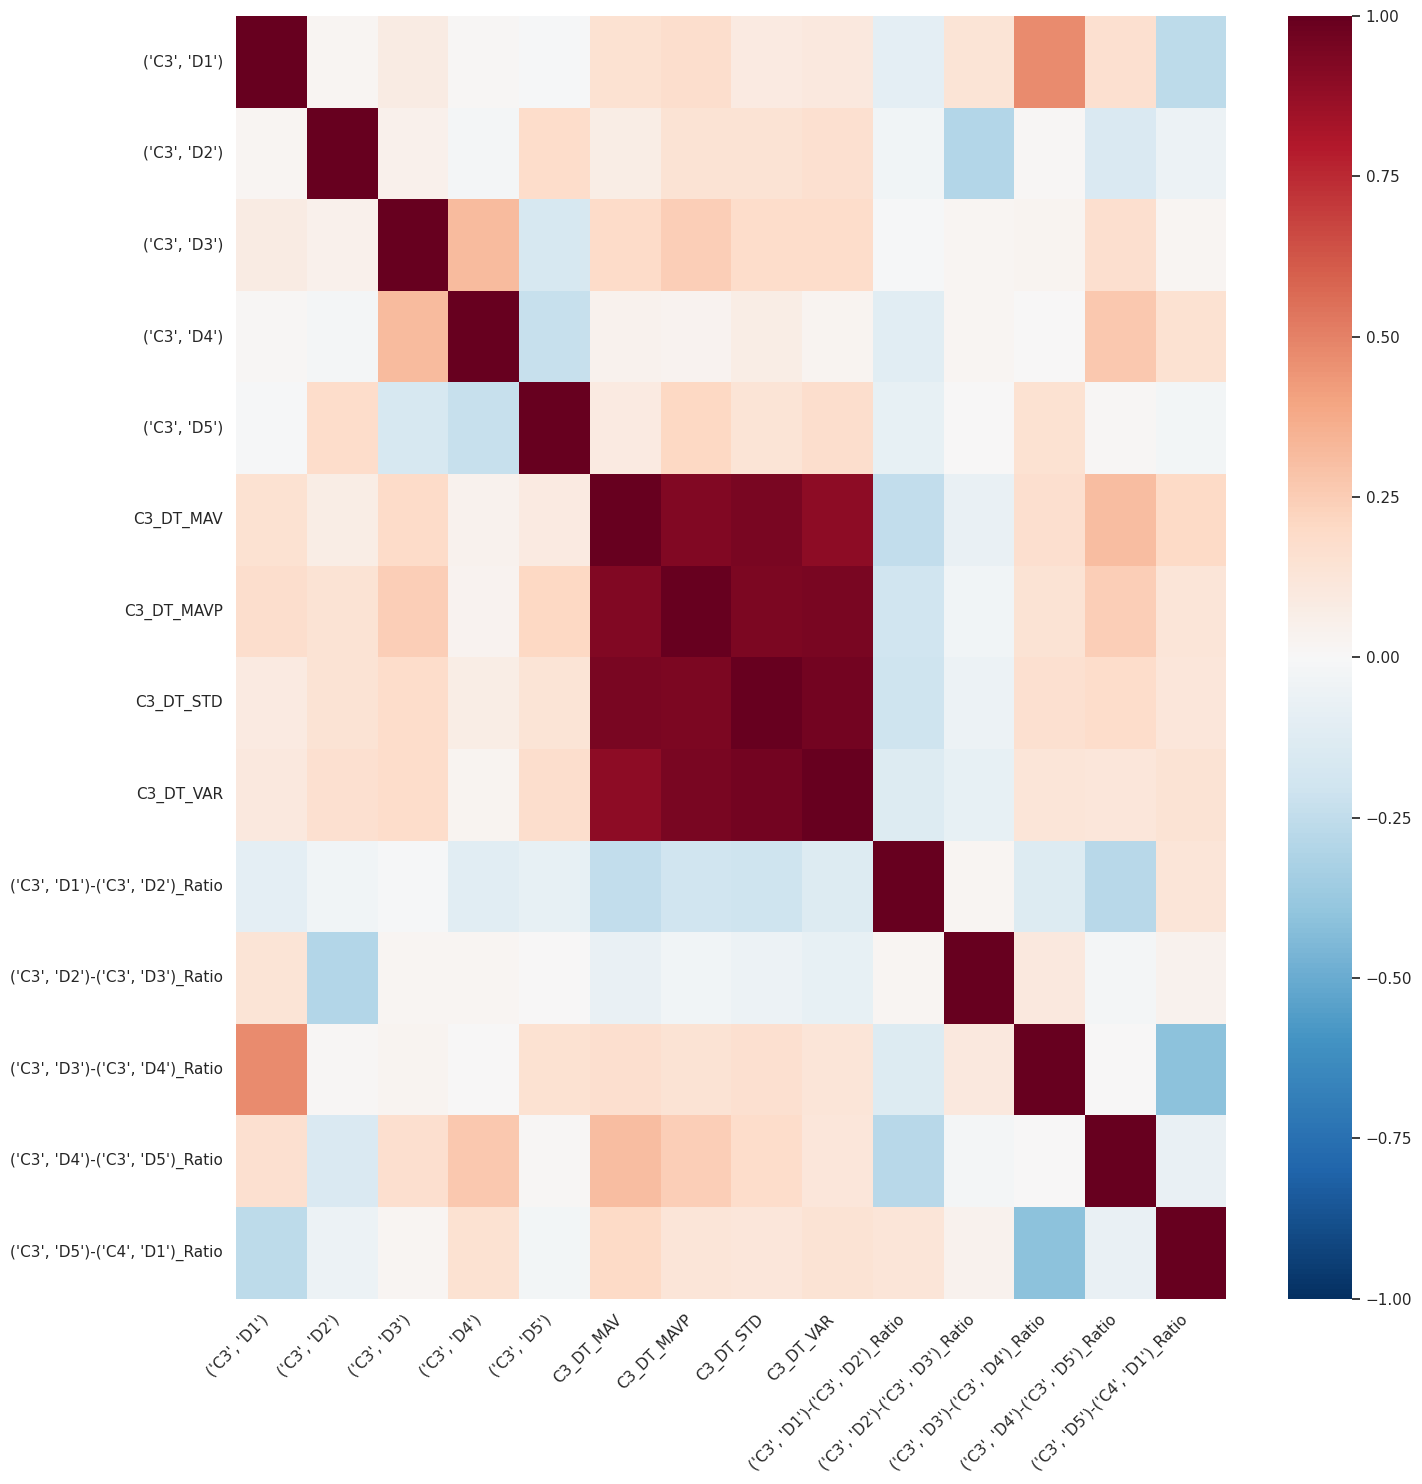

In [39]:
import seaborn as sns; sns.set(color_codes=True)
from IPython.display import Image
import numpy as np


# examine for one channel (eg. C3)
dwt_wavelets_features_removed_C3 = dwt_wavelets_features_removed[["('C3', 'D1')","('C3', 'D2')", "('C3', 'D3')",
 "('C3', 'D4')","('C3', 'D5')",'C3_DT_MAV','C3_DT_MAVP', 'C3_DT_STD','C3_DT_VAR',"('C3', 'D1')-('C3', 'D2')_Ratio",
 "('C3', 'D2')-('C3', 'D3')_Ratio","('C3', 'D3')-('C3', 'D4')_Ratio","('C3', 'D4')-('C3', 'D5')_Ratio",
 "('C3', 'D5')-('C4', 'D1')_Ratio"]]

 

correlations = dwt_wavelets_features_removed_C3.corr()
# plot correlation matrix
plt.figure(figsize=(15,15))
sns.heatmap(correlations, 
            vmin=-1, 
            vmax=1,
            xticklabels=correlations.columns.values,
            yticklabels=correlations.columns.values,
            cmap="RdBu_r"
           )
plt.xticks(rotation=45,ha='right')
plt.tight_layout()
plt.show()

Features removed:  ['C3_DT_MAVP', 'C3_DT_STD', 'C3_DT_VAR']


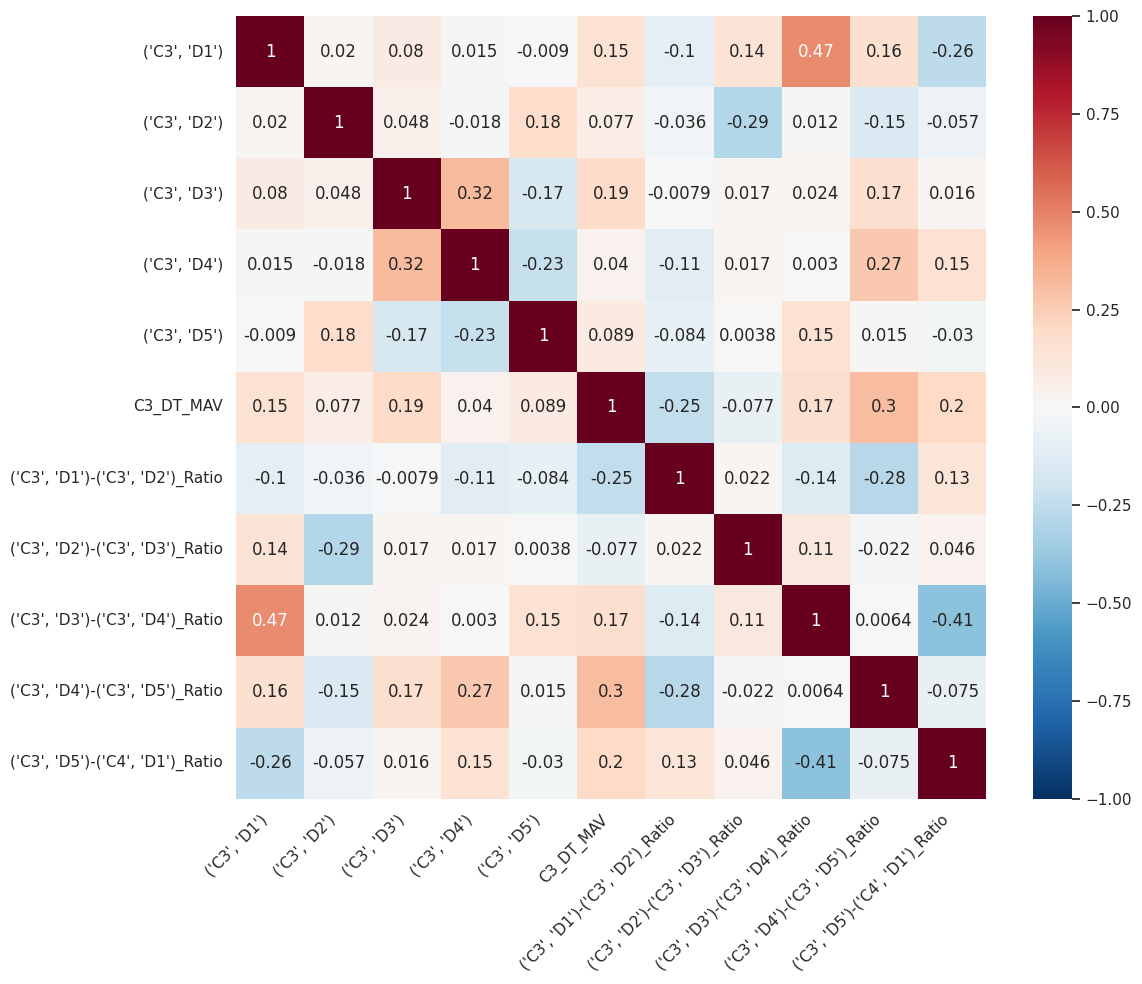

In [42]:
# Assuming dwt_wavelets_features_selected_C3 is already defined as shown previously
correlations = dwt_wavelets_features_removed_C3.corr()

# Set the correlation threshold
threshold = 0.8

# Finding features with correlation greater than the threshold
# np.triu: consider upper triangle of matrix, to avoid double counting pairs
upper = correlations.where(np.triu(np.ones(correlations.shape), k=1).astype(bool))

# Select columns to drop based on threshold
to_drop = [column for column in upper.columns if any(upper[column].abs() > threshold)]

# Revised DataFrame with highly correlated features dropped
revised_features = dwt_wavelets_features_removed_C3.drop(columns=to_drop)
print("Features removed: ", list(to_drop))

# Show the updated correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(revised_features.corr(), vmin=-1, vmax=1, cmap='RdBu_r', annot=True)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Trying for channel O1

Features removed for O1 channel:  ['O1_DT_MAVP', 'O1_DT_STD', 'O1_DT_VAR']


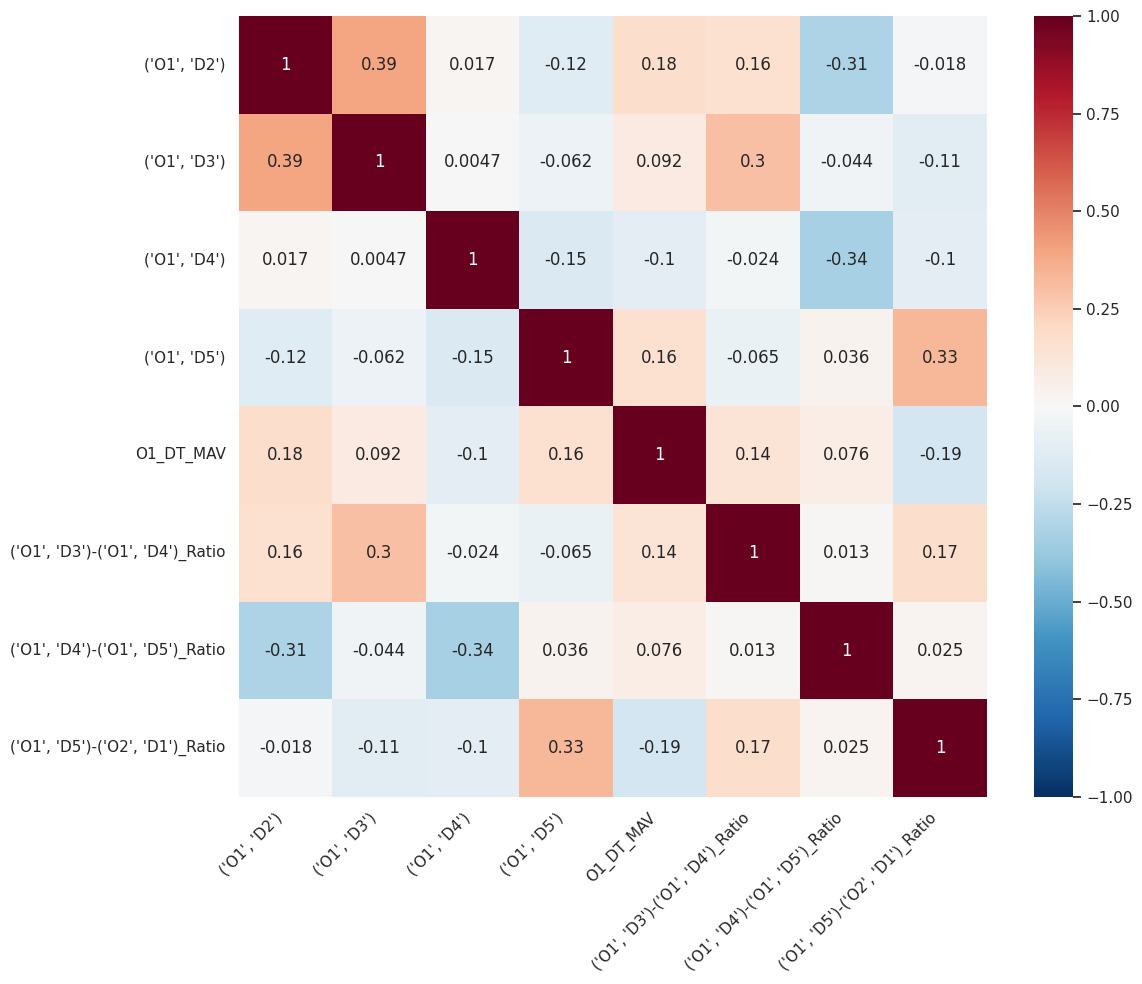

In [49]:
# examine for one channel (eg. O1)
dwt_wavelets_features_removed_O1 = dwt_wavelets_features_removed[["('O1', 'D2')","('O1', 'D3')", "('O1', 'D4')", "('O1', 'D5')", 'O1_DT_MAV','O1_DT_MAVP','O1_DT_STD','O1_DT_VAR',
"('O1', 'D3')-('O1', 'D4')_Ratio","('O1', 'D4')-('O1', 'D5')_Ratio","('O1', 'D5')-('O2', 'D1')_Ratio"]]

correlations2 = dwt_wavelets_features_removed_O1.corr()

upper = correlations2.where(np.triu(np.ones(correlations2.shape), k=1).astype(bool))

# Select columns to drop based on threshold
to_drop = [column for column in upper.columns if any(upper[column].abs() > threshold)]

# Revised DataFrame with highly correlated features dropped
revised_features2 = dwt_wavelets_features_removed_O1.drop(columns=to_drop)
print("Features removed for O1 channel: ", list(to_drop))

# Show the updated correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(revised_features2.corr(), vmin=-1, vmax=1, cmap='RdBu_r', annot=True)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Trying for channel Fz

Features removed for Fz channel:  ['Fz_DT_MAVP', 'Fz_DT_STD', 'Fz_DT_VAR']


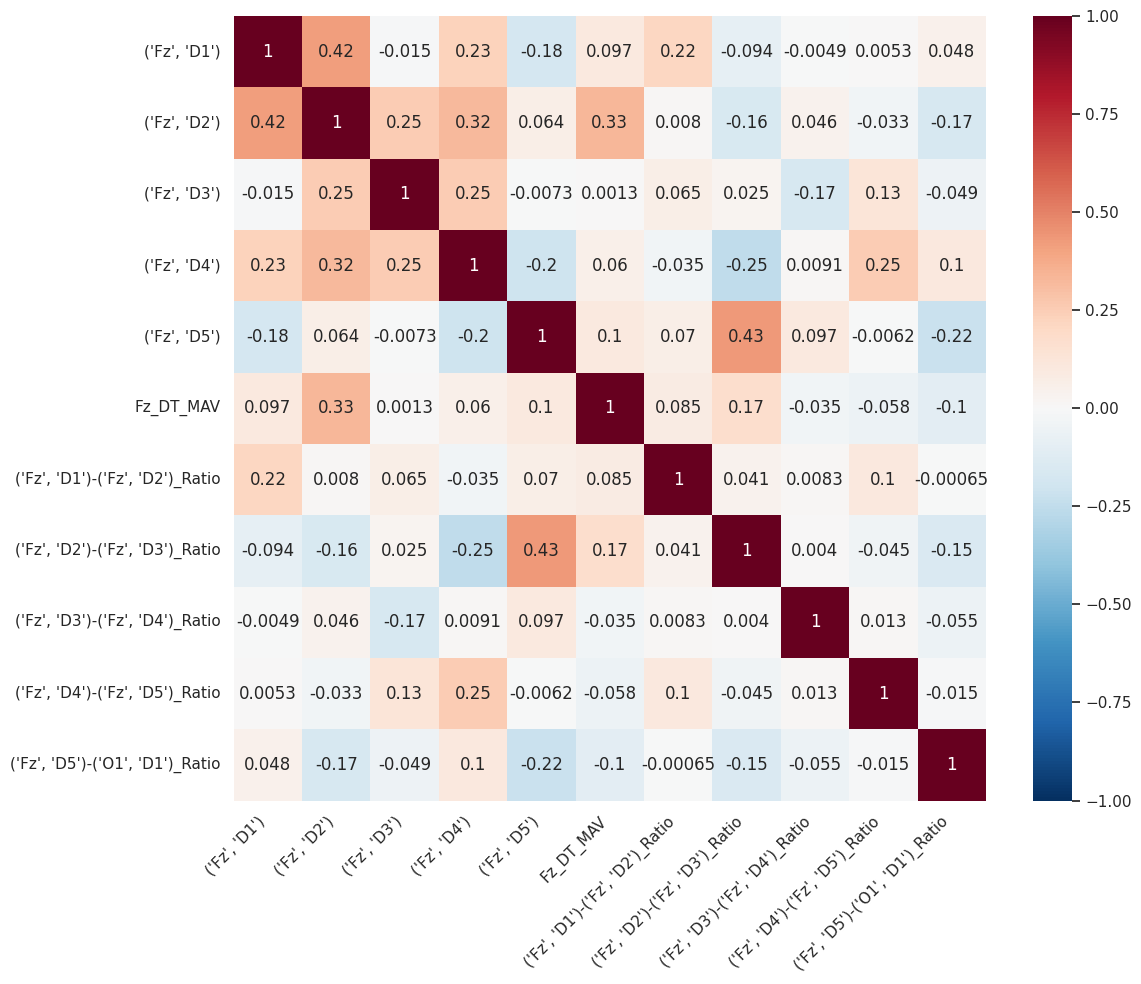

In [52]:
# examine for one channel (eg. Fz)
dwt_wavelets_features_removed_Fz = dwt_wavelets_features_removed[["('Fz', 'D1')","('Fz', 'D2')","('Fz', 'D3')","('Fz', 'D4')","('Fz', 'D5')",'Fz_DT_MAV',
'Fz_DT_MAVP','Fz_DT_STD', 'Fz_DT_VAR',"('Fz', 'D1')-('Fz', 'D2')_Ratio","('Fz', 'D2')-('Fz', 'D3')_Ratio",
 "('Fz', 'D3')-('Fz', 'D4')_Ratio", "('Fz', 'D4')-('Fz', 'D5')_Ratio","('Fz', 'D5')-('O1', 'D1')_Ratio"]]

correlations3 = dwt_wavelets_features_removed_Fz.corr()

upper = correlations3.where(np.triu(np.ones(correlations3.shape), k=1).astype(bool))

# Select columns to drop based on threshold
to_drop = [column for column in upper.columns if any(upper[column].abs() > threshold)]

# Revised DataFrame with highly correlated features dropped
revised_features2 = dwt_wavelets_features_removed_Fz.drop(columns=to_drop)
print("Features removed for Fz channel: ", list(to_drop))

# Show the updated correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(revised_features2.corr(), vmin=-1, vmax=1, cmap='RdBu_r', annot=True)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

General features to remove: ['DT_MAVP', 'DT_STD', 'DT_VAR']

## 6c. Preparing data for CNN model (sample with 5 EEG_ids)

In [53]:
for eeg_segment, target_labels, eeg_id in loader():
    
    print(f'EEG ID: {eeg_id}')
    eeg_segment = pd.DataFrame(eeg_segment)
    print(eeg_segment.shape)
    display(eeg_segment)
    target_labels = pd.DataFrame(target_labels)
    display(target_labels)
    

Number of offset subsamples for EEG ID 1628180742 : 9
EEG ID: 1628180742
(2000, 20)


,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-80.519997,-70.540001,-80.110001,-108.750000,-120.330002,-88.620003,-101.750000,-104.489998,-99.129997,-90.389999,-97.040001,-77.989998,-88.830002,-112.120003,-108.110001,-95.949997,-98.360001,-121.730003,-106.449997,7.920000
1,-80.449997,-70.330002,-81.760002,-107.669998,-120.769997,-90.820000,-104.260002,-99.730003,-99.070000,-92.290001,-96.019997,-84.500000,-84.989998,-115.610001,-103.860001,-97.470001,-89.290001,-115.500000,-102.059998,29.219999
2,-80.209999,-75.870003,-82.050003,-106.010002,-117.500000,-87.489998,-99.589996,-96.820000,-119.680000,-99.360001,-91.110001,-99.440002,-104.589996,-127.529999,-113.349998,-95.870003,-96.019997,-123.879997,-105.790001,45.740002
3,-84.709999,-75.339996,-87.480003,-108.970001,-121.410004,-94.750000,-105.370003,-100.279999,-113.839996,-102.059998,-95.040001,-99.230003,-101.220001,-125.769997,-111.889999,-97.459999,-97.180000,-128.940002,-109.889999,83.870003
4,-90.570000,-80.790001,-93.000000,-113.870003,-129.960007,-102.860001,-118.599998,-101.099998,-107.660004,-102.339996,-98.510002,-95.300003,-88.930000,-115.639999,-99.800003,-97.500000,-88.730003,-114.849998,-100.250000,97.769997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-128.380005,-131.750000,-118.970001,-144.710007,-180.110001,-123.870003,-123.559998,-104.480003,-136.330002,-105.360001,-97.790001,-122.050003,-110.720001,-120.050003,-97.239998,-78.070000,-87.870003,-106.139999,-84.919998,19.879999
1996,-130.050003,-135.289993,-125.190002,-149.190002,-181.169998,-129.110001,-128.600006,-109.720001,-133.880005,-111.220001,-106.860001,-121.769997,-111.639999,-131.330002,-103.629997,-80.559998,-95.040001,-111.730003,-87.650002,7.920000
1997,-135.500000,-141.279999,-133.899994,-154.270004,-187.539993,-131.750000,-134.429993,-114.209999,-137.470001,-121.690002,-117.790001,-122.769997,-114.639999,-140.210007,-109.949997,-90.089996,-93.730003,-113.680000,-91.930000,-50.520000
1998,-137.529999,-150.770004,-139.360001,-153.369995,-182.919998,-130.350006,-127.099998,-110.699997,-159.839996,-133.440002,-118.800003,-139.820007,-136.050003,-151.029999,-122.099998,-97.290001,-99.160004,-126.500000,-96.250000,-53.380001


,0
seizure_vote,3
lpd_vote,0
gpd_vote,0
lrda_vote,0
grda_vote,0
other_vote,0


EEG ID: 1628180742
(2000, 20)


,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-129.460007,-115.580002,-115.129997,-157.440002,-166.979996,-126.260002,-133.429993,-124.349998,-116.629997,-112.110001,-117.040001,-103.169998,-100.070000,-133.970001,-103.449997,-100.059998,-90.040001,-132.460007,-107.230003,-5.900000
1,-128.740005,-112.330002,-112.059998,-154.830002,-164.440002,-121.230003,-135.380005,-122.269997,-114.930000,-107.370003,-111.059998,-100.480003,-96.330002,-122.019997,-95.400002,-98.309998,-83.660004,-122.070000,-97.180000,9.670000
2,-128.600006,-112.550003,-107.489998,-148.360001,-154.089996,-114.110001,-129.470001,-115.989998,-123.620003,-104.839996,-100.190002,-104.250000,-106.040001,-116.940002,-96.059998,-96.620003,-91.120003,-127.430000,-93.900002,-3.030000
3,-123.449997,-106.440002,-108.870003,-148.309998,-158.080002,-118.129997,-133.350006,-117.790001,-106.150002,-95.480003,-97.440002,-93.980003,-90.500000,-109.900002,-86.510002,-93.559998,-86.019997,-121.650002,-92.110001,33.880001
4,-129.770004,-119.430000,-111.879997,-148.029999,-145.830002,-118.040001,-140.699997,-113.980003,-97.209999,-85.459999,-91.620003,-83.529999,-71.750000,-96.820000,-71.599998,-85.779999,-68.370003,-105.889999,-85.059998,65.309998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-124.599998,-123.930000,-114.550003,-134.649994,-168.350006,-120.279999,-112.779999,-102.169998,-135.960007,-103.190002,-89.910004,-113.959999,-117.680000,-130.380005,-122.610001,-98.400002,-92.209999,-131.000000,-93.480003,48.380001
1996,-117.559998,-116.239998,-111.989998,-135.679993,-163.660004,-116.449997,-112.160004,-105.580002,-126.470001,-103.760002,-95.889999,-107.139999,-111.570000,-132.740005,-125.309998,-94.940002,-93.290001,-135.699997,-98.589996,34.450001
1997,-111.320000,-110.900002,-112.839996,-136.550003,-163.809998,-116.750000,-115.110001,-106.480003,-115.779999,-101.680000,-101.910004,-94.879997,-98.120003,-124.650002,-120.120003,-94.190002,-77.900002,-127.099998,-95.489998,-16.930000
1998,-111.050003,-113.389999,-110.309998,-135.690002,-157.639999,-112.279999,-109.050003,-105.690002,-134.039993,-110.440002,-100.139999,-107.959999,-117.220001,-136.440002,-131.490005,-93.019997,-78.449997,-136.410004,-101.169998,-35.509998


,0
seizure_vote,3
lpd_vote,0
gpd_vote,0
lrda_vote,0
grda_vote,0
other_vote,0


EEG ID: 1628180742
(2000, 20)


,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-78.440002,-91.230003,-95.889999,-122.519997,-82.949997,-101.040001,-113.190002,-91.160004,-121.019997,-104.110001,-90.449997,-115.879997,-114.459999,-137.860001,-127.010002,-156.679993,-112.089996,-131.130005,-98.800003,8.070000
1,-78.629997,-88.500000,-92.010002,-116.199997,-77.089996,-91.150002,-107.320000,-86.900002,-126.750000,-106.080002,-86.480003,-118.110001,-120.059998,-152.979996,-136.380005,-152.809998,-100.080002,-136.009995,-101.209999,-9.260000
2,-75.620003,-86.169998,-87.650002,-108.800003,-70.529999,-88.150002,-102.190002,-78.970001,-128.789993,-101.510002,-77.879997,-118.150002,-120.800003,-139.059998,-140.990005,-152.750000,-106.050003,-145.800003,-102.730003,27.950001
3,-72.930000,-87.269997,-85.150002,-106.959999,-73.209999,-85.779999,-97.480003,-81.839996,-120.610001,-99.449997,-80.120003,-112.370003,-116.150002,-130.419998,-138.850006,-156.399994,-116.480003,-148.250000,-109.559998,49.439999
4,-76.459999,-93.150002,-92.089996,-107.970001,-76.199997,-96.250000,-102.910004,-81.639999,-122.790001,-100.690002,-82.230003,-110.820000,-119.510002,-134.960007,-130.789993,-162.059998,-120.839996,-138.979996,-104.870003,29.820000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-129.270004,-140.229996,-128.300003,-156.000000,-151.759995,-127.699997,-139.979996,-118.910004,-168.080002,-124.519997,-94.650002,-146.970001,-147.210007,-144.279999,-114.720001,-131.600006,-108.260002,-127.820000,-92.389999,52.049999
1996,-126.089996,-138.279999,-127.989998,-157.190002,-156.410004,-132.710007,-143.479996,-119.879997,-154.020004,-118.580002,-93.339996,-135.699997,-134.210007,-132.960007,-114.279999,-128.710007,-112.620003,-131.990005,-95.860001,88.849998
1997,-134.520004,-145.589996,-136.539993,-163.869995,-166.050003,-143.440002,-149.929993,-123.040001,-152.649994,-120.690002,-97.190002,-133.160004,-128.729996,-140.610001,-111.940002,-130.839996,-109.330002,-127.360001,-94.279999,31.110001
1998,-141.869995,-150.770004,-135.509995,-160.630005,-168.869995,-144.050003,-145.869995,-116.529999,-158.529999,-116.860001,-86.959999,-136.440002,-132.440002,-137.110001,-107.769997,-124.940002,-96.019997,-127.129997,-91.370003,33.320000


,0
seizure_vote,3
lpd_vote,0
gpd_vote,0
lrda_vote,0
grda_vote,0
other_vote,0


EEG ID: 1628180742
(2000, 20)


,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-138.520004,-147.820007,-139.910004,-163.320007,-174.929993,-151.270004,-154.979996,-115.160004,-132.669998,-102.570000,-80.610001,-107.050003,-103.959999,-112.610001,-86.720001,-100.790001,-74.639999,-108.449997,-83.910004,-23.480000
1,-146.270004,-154.699997,-142.839996,-167.389999,-177.729996,-153.869995,-153.660004,-117.709999,-143.270004,-105.430000,-80.309998,-120.790001,-107.320000,-115.779999,-86.000000,-98.599998,-67.970001,-104.209999,-83.760002,-49.290001
2,-155.009995,-159.250000,-146.149994,-170.039993,-181.839996,-153.940002,-153.949997,-119.559998,-147.800003,-107.839996,-82.529999,-117.419998,-112.720001,-110.040001,-90.330002,-96.260002,-65.760002,-108.790001,-85.750000,-0.590000
3,-155.169998,-156.600006,-147.679993,-170.929993,-184.229996,-156.970001,-155.750000,-119.150002,-135.470001,-103.570000,-84.889999,-103.580002,-103.599998,-106.629997,-84.430000,-99.550003,-66.379997,-102.260002,-83.470001,12.760000
4,-158.869995,-155.419998,-146.800003,-169.339996,-185.199997,-154.470001,-154.470001,-118.120003,-135.910004,-102.209999,-84.290001,-110.910004,-101.919998,-107.580002,-83.339996,-98.910004,-63.980000,-97.870003,-80.739998,-15.370000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-122.290001,-124.809998,-117.870003,-144.149994,-141.830002,-105.279999,-116.639999,-134.259995,-154.000000,-118.550003,-104.980003,-131.649994,-127.820000,-172.500000,-178.240005,-112.169998,-118.730003,-153.690002,-114.610001,108.809998
1996,-120.529999,-122.750000,-118.879997,-143.580002,-144.869995,-107.269997,-124.230003,-133.610001,-142.649994,-115.480003,-107.699997,-128.539993,-118.430000,-159.570007,-177.160004,-123.510002,-126.169998,-151.559998,-115.430000,110.879997
1997,-119.470001,-119.550003,-115.010002,-142.139999,-147.399994,-103.910004,-127.199997,-129.130005,-141.520004,-114.989998,-107.769997,-116.400002,-111.300003,-171.000000,-173.139999,-111.309998,-105.830002,-143.770004,-112.989998,63.020000
1998,-125.080002,-122.639999,-114.510002,-138.190002,-147.880005,-100.400002,-109.370003,-129.979996,-155.679993,-121.870003,-108.510002,-122.040001,-121.779999,-175.839996,-182.509995,-96.419998,-82.410004,-153.289993,-118.400002,74.790001


,0
seizure_vote,3
lpd_vote,0
gpd_vote,0
lrda_vote,0
grda_vote,0
other_vote,0


EEG ID: 1628180742
(2000, 20)


,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-100.360001,-131.580002,-123.239998,-143.029999,-92.760002,-81.739998,-107.230003,-134.789993,-177.490005,-140.699997,-137.490005,-161.479996,-161.350006,-181.130005,-169.720001,-175.639999,-152.880005,-165.360001,-130.220001,26.879999
1,-99.839996,-125.480003,-109.330002,-135.009995,-91.620003,-76.019997,-99.989998,-129.529999,-187.779999,-141.720001,-130.860001,-166.110001,-170.360001,-189.020004,-170.199997,-171.220001,-143.240005,-166.610001,-129.070007,19.870001
2,-106.459999,-130.570007,-114.820000,-136.429993,-94.800003,-79.760002,-98.910004,-131.520004,-190.580002,-143.240005,-130.910004,-170.649994,-171.490005,-182.250000,-172.550003,-174.279999,-162.029999,-173.009995,-132.720001,57.450001
3,-102.029999,-127.500000,-117.930000,-138.529999,-97.269997,-81.339996,-104.419998,-131.309998,-177.830002,-142.779999,-134.740005,-158.410004,-160.649994,-192.080002,-165.020004,-165.070007,-138.270004,-164.419998,-129.570007,44.869999
4,-104.790001,-127.330002,-115.620003,-136.380005,-100.059998,-85.639999,-103.389999,-125.930000,-184.679993,-142.960007,-130.339996,-166.360001,-164.820007,-180.889999,-161.729996,-169.669998,-132.100006,-161.270004,-127.150002,9.510000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-84.489998,-76.419998,-96.639999,-123.120003,-110.500000,-73.639999,-83.209999,-197.679993,-299.070007,-166.009995,-115.809998,-114.400002,-109.949997,-199.110001,-423.399994,-141.580002,-115.279999,-177.399994,-153.699997,69.720001
1996,-69.910004,-57.320000,-101.820000,-119.889999,-99.080002,-64.949997,-82.820000,-197.860001,-285.410004,-171.009995,-127.769997,-100.440002,-98.150002,-232.889999,-435.029999,-122.440002,-121.790001,-187.119995,-159.190002,48.930000
1997,-71.279999,-66.300003,-79.830002,-115.099998,-96.550003,-62.330002,-72.730003,-192.699997,-300.839996,-180.820007,-130.990005,-116.750000,-118.720001,-238.460007,-453.630005,-142.770004,-103.949997,-201.080002,-166.600006,18.580000
1998,-72.199997,-69.529999,-88.589996,-111.720001,-91.040001,-52.750000,-69.099998,-190.740005,-310.459991,-190.149994,-134.600006,-117.769997,-129.669998,-256.549988,-470.149994,-123.209999,-80.430000,-216.649994,-174.850006,50.540001


,0
seizure_vote,3
lpd_vote,0
gpd_vote,0
lrda_vote,0
grda_vote,0
other_vote,0


EEG ID: 1628180742
(2000, 20)


,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-102.489998,-108.830002,-104.290001,-115.790001,-123.709999,-84.300003,-97.570000,-111.000000,-134.619995,-109.690002,-88.320000,-108.300003,-110.300003,-131.389999,-113.449997,-103.480003,-81.589996,-106.269997,-117.279999,-51.540001
1,-103.519997,-113.220001,-104.349998,-115.989998,-118.839996,-83.120003,-98.620003,-109.300003,-151.610001,-116.360001,-88.400002,-118.919998,-123.949997,-136.119995,-123.919998,-103.320000,-84.709999,-114.260002,-119.370003,-58.400002
2,-101.029999,-114.230003,-107.370003,-118.610001,-116.739998,-83.599998,-101.260002,-110.040001,-153.229996,-119.860001,-92.839996,-121.419998,-132.729996,-138.979996,-134.380005,-110.120003,-92.209999,-126.500000,-127.650002,-19.879999
3,-95.760002,-111.449997,-111.709999,-119.349998,-116.449997,-82.970001,-96.120003,-113.190002,-140.589996,-119.230003,-101.250000,-112.870003,-119.639999,-142.789993,-132.949997,-104.589996,-97.699997,-124.989998,-127.959999,-33.410000
4,-95.120003,-111.510002,-108.519997,-114.930000,-113.739998,-77.279999,-87.629997,-109.139999,-147.399994,-119.389999,-98.570000,-118.610001,-120.970001,-137.470001,-136.550003,-107.870003,-97.099998,-128.029999,-128.130005,-55.099998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-81.940002,-81.940002,-124.519997,-117.820000,-147.770004,-99.730003,-115.680000,-194.639999,-303.679993,-154.839996,-62.980000,-69.820000,-66.449997,-113.110001,-359.709991,-83.639999,-95.070000,-124.750000,-114.800003,-46.310001
1996,-87.410004,-93.279999,-96.239998,-118.059998,-152.360001,-125.889999,-118.309998,-198.820007,-305.160004,-165.830002,-75.519997,-71.680000,-86.129997,-163.699997,-369.019989,-82.180000,-75.339996,-127.410004,-119.180000,-78.879997
1997,-86.059998,-87.120003,-108.040001,-120.720001,-148.460007,-97.440002,-112.110001,-197.210007,-317.730011,-171.119995,-76.470001,-95.209999,-93.989998,-160.869995,-376.420013,-101.839996,-100.480003,-134.990005,-120.300003,-96.550003
1998,-77.790001,-78.220001,-87.040001,-109.470001,-138.919998,-104.529999,-110.010002,-191.570007,-302.410004,-156.520004,-61.110001,-68.440002,-66.650002,-139.009995,-361.540009,-78.180000,-110.650002,-124.209999,-113.480003,-55.320000


,0
seizure_vote,3
lpd_vote,0
gpd_vote,0
lrda_vote,0
grda_vote,0
other_vote,0


EEG ID: 1628180742
(2000, 20)


,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-107.879997,-121.239998,-119.169998,-118.500000,-133.020004,-110.650002,-106.370003,-118.370003,-202.690002,-116.320000,-90.230003,-87.419998,-97.930000,-157.240005,-228.820007,-84.699997,-96.279999,-139.770004,-111.300003,146.520004
1,-113.680000,-125.629997,-113.709999,-121.760002,-135.000000,-108.180000,-105.510002,-122.059998,-221.589996,-128.410004,-96.419998,-105.720001,-123.080002,-192.960007,-247.410004,-103.800003,-80.739998,-156.070007,-119.809998,144.690002
2,-114.349998,-126.279999,-119.389999,-124.559998,-139.960007,-113.910004,-112.690002,-123.620003,-215.169998,-120.699997,-93.239998,-106.839996,-109.989998,-150.320007,-243.100006,-114.559998,-101.769997,-154.350006,-119.669998,178.600006
3,-123.669998,-131.020004,-128.100006,-130.190002,-150.660004,-121.639999,-120.400002,-127.419998,-212.110001,-120.900002,-95.379997,-103.680000,-105.080002,-150.850006,-227.949997,-108.639999,-106.900002,-132.259995,-112.110001,147.990005
4,-146.779999,-149.419998,-142.690002,-138.380005,-163.820007,-131.729996,-122.010002,-127.599998,-241.100006,-130.149994,-90.690002,-133.039993,-129.330002,-162.940002,-218.830002,-118.550003,-94.690002,-115.860001,-103.739998,124.370003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-142.119995,-138.429993,-127.680000,-133.800003,-159.580002,-125.360001,-121.489998,-227.000000,-371.410004,-243.119995,-119.180000,-152.080002,-152.309998,-202.889999,-369.600006,-134.520004,-98.389999,-171.789993,-152.330002,154.600006
1996,-140.490005,-144.600006,-142.639999,-134.000000,-166.490005,-119.550003,-121.959999,-227.479996,-359.910004,-231.029999,-113.339996,-123.500000,-125.510002,-163.660004,-357.160004,-115.690002,-96.989998,-161.470001,-147.850006,112.410004
1997,-129.789993,-120.529999,-119.510002,-127.839996,-154.149994,-112.050003,-119.940002,-225.080002,-355.579987,-223.309998,-107.089996,-127.209999,-127.550003,-159.619995,-359.230011,-140.050003,-112.169998,-164.610001,-146.119995,116.639999
1998,-121.580002,-111.610001,-135.270004,-125.900002,-167.750000,-112.919998,-119.449997,-224.240005,-341.279999,-219.050003,-106.750000,-109.919998,-116.029999,-182.600006,-358.019989,-104.959999,-80.019997,-162.889999,-146.809998,157.610001


,0
seizure_vote,3
lpd_vote,0
gpd_vote,0
lrda_vote,0
grda_vote,0
other_vote,0


EEG ID: 1628180742
(2000, 20)


,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-88.510002,-80.370003,-90.949997,-108.320000,-155.259995,-109.830002,-112.139999,-184.630005,-297.459991,-145.089996,-40.270000,-72.169998,-56.220001,-148.360001,-308.799988,-90.860001,-26.670000,-63.200001,-83.830002,-92.709999
1,-97.760002,-80.050003,-97.379997,-107.169998,-160.979996,-110.669998,-109.680000,-182.630005,-312.339996,-147.600006,-32.480000,-92.559998,-84.370003,-131.550003,-301.369995,-110.059998,-99.379997,-55.790001,-80.129997,-60.540001
2,-102.489998,-88.910004,-122.279999,-115.610001,-165.250000,-118.040001,-116.370003,-188.070007,-313.480011,-153.360001,-41.669998,-95.169998,-85.190002,-147.460007,-301.679993,-99.070000,-73.610001,-53.830002,-80.879997,-37.849998
3,-98.070000,-96.570000,-100.540001,-114.110001,-150.529999,-102.940002,-115.720001,-187.669998,-311.489990,-154.679993,-44.360001,-98.760002,-82.230003,-166.860001,-306.910004,-104.519997,-62.779999,-56.060001,-82.739998,-63.380001
4,-98.230003,-87.410004,-92.250000,-106.550003,-152.399994,-105.790001,-109.540001,-183.779999,-313.290009,-146.869995,-40.869999,-94.959999,-79.110001,-93.489998,-317.429993,-98.370003,-50.349998,-68.879997,-86.900002,-47.160000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-108.970001,-97.669998,-87.779999,-108.529999,-142.669998,-119.860001,-131.130005,-85.239998,-149.589996,-164.020004,-91.260002,-128.740005,-123.839996,-174.419998,-75.940002,-110.830002,-120.889999,-109.099998,-100.680000,139.660004
1996,-103.059998,-89.669998,-132.059998,-132.339996,-126.900002,-92.040001,-115.339996,-88.099998,-159.449997,-169.839996,-98.070000,-140.979996,-121.470001,-130.250000,-81.330002,-184.720001,-116.910004,-112.250000,-102.040001,107.629997
1997,-110.839996,-109.879997,-104.449997,-126.379997,-140.889999,-87.559998,-113.570000,-88.410004,-162.440002,-166.820007,-96.360001,-128.759995,-111.849998,-86.010002,-88.089996,-153.059998,-45.759998,-123.400002,-107.629997,152.250000
1998,-114.239998,-120.959999,-117.230003,-132.619995,-137.580002,-127.379997,-112.970001,-95.760002,-161.119995,-176.210007,-107.830002,-127.730003,-120.529999,-133.889999,-90.190002,-142.649994,-151.970001,-126.489998,-112.000000,148.710007


,0
seizure_vote,3
lpd_vote,0
gpd_vote,0
lrda_vote,0
grda_vote,0
other_vote,0


EEG ID: 1628180742
(2000, 20)


,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-112.980003,-99.430000,-94.419998,-119.199997,-170.039993,-113.739998,-115.370003,-215.600006,-319.640015,-196.029999,-92.949997,-102.900002,-97.709999,-131.520004,-339.820007,-103.589996,-110.720001,-145.649994,-136.190002,163.270004
1,-108.269997,-96.870003,-108.019997,-111.120003,-148.360001,-105.339996,-108.019997,-209.000000,-317.769989,-196.020004,-87.730003,-98.519997,-91.779999,-146.350006,-341.470001,-86.250000,-118.519997,-150.649994,-137.339996,287.459991
2,-110.720001,-100.290001,-121.220001,-114.360001,-151.029999,-115.980003,-114.540001,-210.050003,-311.489990,-197.699997,-92.540001,-103.449997,-91.930000,-149.919998,-335.390015,-119.669998,-104.099998,-143.949997,-134.779999,211.009995
3,-118.139999,-101.250000,-109.650002,-108.410004,-160.190002,-111.650002,-109.730003,-204.080002,-321.100006,-204.199997,-88.699997,-101.910004,-101.129997,-194.050003,-331.100006,-110.980003,-43.470001,-138.000000,-129.279999,-86.070000
4,-106.339996,-93.099998,-123.540001,-105.129997,-164.330002,-112.349998,-105.570000,-195.830002,-320.299988,-195.500000,-73.529999,-96.910004,-91.199997,-172.429993,-322.250000,-74.349998,-106.190002,-132.330002,-122.900002,-668.219971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-140.039993,-128.100006,-137.339996,-160.830002,-153.630005,-136.279999,-137.009995,-93.349998,-145.130005,-155.830002,-124.650002,-123.250000,-127.709999,-169.759995,-68.489998,-117.669998,-69.239998,-115.309998,-123.860001,65.010002
1996,-152.169998,-161.449997,-173.210007,-165.320007,-143.570007,-124.150002,-127.339996,-87.309998,-160.919998,-158.360001,-121.870003,-129.550003,-121.470001,-120.339996,-68.029999,-135.130005,-105.190002,-114.330002,-121.029999,47.090000
1997,-149.619995,-147.479996,-171.960007,-152.589996,-137.279999,-105.550003,-122.220001,-80.010002,-156.039993,-155.119995,-116.360001,-118.099998,-113.690002,-102.760002,-67.839996,-120.410004,-109.099998,-116.419998,-119.099998,95.589996
1998,-126.860001,-122.889999,-125.879997,-130.339996,-134.779999,-134.350006,-127.080002,-76.739998,-137.649994,-146.800003,-111.720001,-114.199997,-106.739998,-104.699997,-60.240002,-154.119995,-129.639999,-110.029999,-116.239998,72.980003


,0
seizure_vote,3
lpd_vote,0
gpd_vote,0
lrda_vote,0
grda_vote,0
other_vote,0


Number of offset subsamples for EEG ID 2277392603 : 2
EEG ID: 2277392603
(2000, 20)


,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,6.93,2.920000,32.240002,5.590000,23.190001,24.129999,35.189999,23.629999,-15.310000,-6.590000,-5.11,-25.850000,-4.97,17.830000,-36.639999,2.80,-6.70,-13.870000,-17.770000,12.030000
1,11.92,7.850000,35.720001,16.020000,25.700001,24.080000,34.650002,26.190001,-8.810000,-4.970000,-4.54,-20.860001,-0.98,17.820000,-25.639999,3.76,-8.80,-14.800000,-16.100000,28.650000
2,15.48,10.610000,34.720001,26.410000,26.959999,20.129999,32.990002,25.900000,-1.850000,-2.510000,-3.65,-14.860000,3.21,18.760000,-15.500000,3.39,-11.83,-15.370000,-16.040001,31.340000
3,7.77,4.420000,31.670000,5.940000,22.350000,21.040001,31.690001,19.850000,-12.000000,-7.850000,-9.41,-23.350000,-2.60,16.389999,-36.040001,3.11,-8.40,-16.780001,-20.840000,12.780000
4,7.88,4.210000,31.750000,4.040000,22.120001,20.629999,31.690001,19.469999,-13.070000,-9.360000,-11.79,-24.650000,-3.83,14.040000,-38.110001,2.86,-8.32,-17.790001,-22.219999,21.030001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1.00,-21.920000,-7.550000,0.790000,-11.070000,-34.459999,-5.200000,11.370000,-17.070000,-21.270000,-8.42,0.400000,6.64,10.620000,-15.620000,11.87,-6.17,-18.379999,-14.270000,17.500000
1996,-1.47,-23.799999,-9.910000,-10.080000,-12.240000,-32.590000,-4.830000,8.600000,-21.700001,-23.180000,-10.49,-1.640000,4.49,10.790000,-26.610001,11.76,-3.73,-18.889999,-16.900000,2.320000
1997,-4.24,-26.209999,-8.350000,-23.219999,-13.610000,-29.889999,-3.230000,6.240000,-27.930000,-25.980000,-13.57,-6.980000,0.42,8.170000,-40.119999,13.27,-1.36,-18.450001,-18.490000,-5.840000
1998,3.10,-20.049999,-5.110000,-3.090000,-7.460000,-28.650000,-1.380000,12.300000,-17.040001,-20.150000,-7.48,0.980000,5.71,10.070000,-19.510000,14.36,-4.43,-16.709999,-13.540000,14.960000


,9
seizure_vote,0
lpd_vote,0
gpd_vote,5
lrda_vote,0
grda_vote,1
other_vote,5


EEG ID: 2277392603
(2000, 20)


,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-38.820000,-48.209999,-16.340000,-29.18,-37.770000,-46.480000,-6.150000,11.87,-47.320000,-28.000000,-19.08,-44.290001,-15.140000,9.110000,-42.220001,-4.57,-11.10,-17.680000,-22.620001,8.760000
1,-36.549999,-48.849998,-17.480000,-19.26,-38.860001,-51.250000,-9.500000,13.85,-43.240002,-28.059999,-18.68,-38.990002,-12.970000,8.700000,-32.040001,-2.92,-12.56,-18.230000,-21.990000,26.420000
2,-37.419998,-51.950001,-21.850000,-11.65,-43.099998,-58.529999,-14.670000,12.94,-40.119999,-29.160000,-17.98,-32.070000,-9.170000,8.840000,-22.490000,-1.75,-13.47,-19.760000,-22.969999,29.450001
3,-45.889999,-61.720001,-27.790001,-34.66,-50.090000,-60.160000,-17.719999,4.66,-53.459999,-36.490002,-25.58,-39.980000,-15.250000,5.860000,-43.430000,-0.70,-9.18,-21.870001,-29.330000,11.440000
4,-47.090000,-65.139999,-30.170000,-36.50,-51.619999,-61.959999,-19.809999,3.19,-55.880001,-40.020000,-28.08,-40.570000,-16.080000,3.960000,-45.630001,0.53,-8.55,-22.650000,-31.360001,18.469999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,12.330000,6.080000,13.440000,0.39,5.960000,-11.710000,0.840000,3.69,4.880000,-2.150000,-12.73,5.370000,22.790001,15.080000,-21.190001,14.59,-4.03,-23.930000,-22.350000,13.380000
1996,8.380000,3.280000,11.920000,-10.10,2.860000,-11.720000,-0.550000,-0.21,0.600000,-3.340000,-15.85,1.990000,20.900000,15.370000,-31.670000,13.47,-3.59,-25.410000,-24.930000,-0.150000
1997,4.720000,1.020000,11.970000,-23.91,0.570000,-10.070000,-0.650000,-2.11,-6.670000,-4.730000,-17.75,-4.020000,17.299999,15.490000,-45.799999,14.75,0.72,-24.610001,-26.049999,-7.210000
1998,11.150000,7.130000,16.120001,-4.66,4.760000,-11.000000,-0.410000,2.08,4.320000,1.690000,-12.27,2.870000,22.629999,18.639999,-24.920000,16.27,-1.59,-22.219999,-21.930000,14.390000


,9
seizure_vote,0
lpd_vote,0
gpd_vote,5
lrda_vote,0
grda_vote,1
other_vote,5


Number of offset subsamples for EEG ID 722738444 : 11
EEG ID: 722738444
(2000, 20)


,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-33.500000,-15.950000,27.120001,19.670000,10.100000,18.610001,27.379999,-2.13,-16.750000,1.860000,-3.190000,-52.900002,-44.400002,25.790001,13.560000,-20.740000,-77.089996,-58.220001,-22.059999,-2.390000
1,-30.570000,-12.760000,28.180000,21.530001,13.030000,15.150000,27.379999,0.00,-15.680000,2.920000,0.530000,-52.369999,-44.930000,30.570000,22.330000,-21.799999,-70.180000,-48.650002,-18.340000,2.930000
2,-34.029999,-18.610001,24.990000,15.420000,4.790000,13.560000,22.059999,-5.05,-18.340000,0.530000,-4.790000,-55.830002,-48.910000,29.240000,25.790001,-19.940001,-62.740002,-46.790001,-22.330000,2.390000
3,-32.430000,-18.610001,26.850000,19.139999,5.050000,13.290000,24.190001,0.00,-19.940001,3.720000,0.000000,-55.029999,-47.590000,31.900000,34.029999,-11.170000,-53.700001,-39.610001,-16.219999,-3.460000
4,-30.309999,-11.700000,34.029999,27.650000,13.560000,21.270000,34.560001,10.37,-19.410000,8.240000,8.770000,-55.560001,-47.590000,32.959999,42.529999,-8.240000,-47.849998,-27.910000,-4.250000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,39.080002,38.279999,22.600000,1.060000,33.230000,-11.430000,11.430000,0.00,2.130000,-15.420000,-26.850000,-1.860000,-17.549999,-0.530000,-65.400002,35.619999,-22.330000,-14.620000,3.460000,-30.570000
1996,33.230000,28.980000,17.010000,-2.660000,23.129999,-17.809999,6.110000,-1.33,-0.800000,-17.809999,-29.770000,-3.190000,-18.080000,0.800000,-63.799999,37.480000,-18.870001,-17.549999,0.800000,-31.900000
1997,32.700001,28.180000,19.940001,4.520000,24.719999,-12.760000,13.820000,8.77,0.270000,-12.230000,-21.000000,-0.800000,-13.820000,7.180000,-59.020000,43.860001,-14.090000,-12.490000,9.570000,-31.100000
1998,31.900000,27.120001,19.670000,7.440000,26.580000,-12.760000,14.890000,13.29,2.390000,-11.960000,-17.280001,-2.390000,-10.630000,9.570000,-56.619999,42.799999,-13.820000,-7.980000,13.820000,-23.920000


,11
seizure_vote,0
lpd_vote,1
gpd_vote,0
lrda_vote,14
grda_vote,0
other_vote,1


EEG ID: 722738444
(2000, 20)


,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,65.400002,43.599998,9.04,-15.680000,30.309999,-9.57,-7.980000,-6.110000,34.560001,-36.689999,-53.430000,26.32,9.300000,-31.370001,-43.599998,52.639999,-2.92,10.630000,-29.770000,4.520000
1,63.799999,43.599998,8.51,-15.420000,31.100000,-8.24,-7.710000,-5.320000,34.290001,-37.750000,-53.169998,25.52,9.570000,-32.700001,-42.000000,50.240002,1.06,14.620000,-27.650000,8.510000
2,63.799999,39.880001,3.19,-22.600000,27.379999,-13.82,-15.150000,-12.760000,34.029999,-42.799999,-60.349998,24.99,7.440000,-36.419998,-43.599998,49.180000,1.60,13.820000,-32.169998,9.830000
3,63.799999,41.470001,3.99,-22.059999,30.570000,-10.63,-13.820000,-11.960000,35.889999,-40.410000,-57.419998,26.58,9.840000,-35.619999,-41.740002,53.430000,3.46,12.760000,-30.040001,3.450000
4,63.000000,44.130001,7.98,-19.139999,34.560001,-5.32,-12.490000,-9.040000,35.360001,-38.549999,-55.290001,26.32,10.630000,-36.419998,-44.660000,51.840000,2.13,13.290000,-26.580000,6.110000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-4.250000,-2.920000,19.67,10.900000,-8.510000,-26.85,9.570000,11.960000,-19.670000,-5.050000,-2.390000,-13.82,-24.459999,21.799999,-9.840000,27.379999,-7.98,-18.610001,28.180000,-98.620003
1996,-0.530000,-6.380000,15.15,4.790000,-10.630000,-30.57,3.720000,4.790000,-19.940001,-8.240000,-8.510000,-12.76,-25.520000,21.799999,-8.510000,30.840000,-3.46,-18.080000,23.389999,-98.360001
1997,1.060000,-2.920000,21.27,13.030000,-4.250000,-21.27,13.820000,13.030000,-18.870001,-3.990000,-2.130000,-8.51,-22.330000,24.719999,-2.920000,36.950001,2.39,-6.650000,31.629999,-96.769997
1998,0.800000,0.800000,26.85,19.670000,2.390000,-9.30,24.459999,21.000000,-18.340000,-2.920000,2.390000,-8.24,-20.200001,25.250000,0.000000,35.360001,6.11,0.270000,37.750000,-90.120003


,11
seizure_vote,0
lpd_vote,1
gpd_vote,0
lrda_vote,14
grda_vote,0
other_vote,1


EEG ID: 722738444
(2000, 20)


,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-15.150000,-16.480000,18.080000,8.24,-10.630000,-4.79,30.570000,6.65,8.770000,-15.950000,-21.530001,20.469999,6.65,-40.939999,-68.320000,23.660000,-97.559998,-33.759998,-26.850000,-3.45
1,-15.950000,-15.420000,19.139999,12.23,-10.370000,-2.66,31.370001,7.44,9.840000,-15.680000,-19.410000,20.469999,9.30,-42.000000,-63.799999,22.600000,-92.510002,-28.440001,-24.190001,1.86
2,-16.219999,-19.670000,13.290000,3.72,-15.420000,-9.30,23.129999,-2.13,7.980000,-20.740000,-25.520000,17.549999,6.38,-44.930000,-62.209999,23.660000,-86.129997,-32.959999,-31.900000,5.05
3,-14.360000,-21.270000,10.630000,1.06,-17.549999,-14.09,17.010000,-4.25,9.040000,-19.670000,-26.320000,21.530001,8.24,-44.130001,-57.950001,31.370001,-75.230003,-23.930000,-30.040001,-1.33
4,-13.030000,-16.750000,15.680000,7.18,-12.230000,-6.91,25.520000,0.80,11.700000,-16.750000,-19.940001,23.930000,10.37,-41.740002,-56.090000,32.959999,-69.379997,-11.170000,-22.059999,2.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,97.029999,82.940002,32.959999,8.77,78.419998,12.23,29.770000,5.05,31.370001,-35.889999,-21.000000,33.759998,-8.24,-53.169998,-36.150002,43.860001,26.580000,36.950001,48.910000,2.39
1996,96.230003,79.220001,28.440001,1.06,73.900002,9.04,23.660000,0.00,30.309999,-40.410000,-28.709999,32.430000,-8.77,-53.970001,-40.139999,43.860001,27.120001,33.500000,43.330002,2.12
1997,92.779999,77.620003,28.980000,3.46,72.570000,8.24,26.049999,3.46,31.629999,-36.950001,-25.250000,33.500000,-4.25,-48.380001,-38.810001,48.119999,31.100000,37.220001,47.849998,-1.06
1998,92.250000,80.550003,29.770000,7.44,75.230003,10.63,28.980000,7.98,32.169998,-35.619999,-20.740000,32.700001,-3.46,-43.330002,-40.139999,46.259998,31.629999,41.200001,51.570000,1.86


,11
seizure_vote,0
lpd_vote,1
gpd_vote,0
lrda_vote,14
grda_vote,0
other_vote,1


EEG ID: 722738444
(2000, 20)


,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-16.219999,-26.049999,-23.389999,-38.279999,-66.459999,-117.500000,-65.930000,-41.200001,19.410000,-27.120001,-64.330002,1.060000,0.000000,-24.990000,-128.929993,36.689999,-48.910000,-85.599998,-87.199997,-5.05
1,-19.670000,-23.129999,-16.750000,-31.100000,-62.470001,-106.070000,-57.689999,-34.290001,18.610001,-24.459999,-58.750000,0.000000,0.800000,-24.190001,-128.669998,35.889999,-46.790001,-84.540001,-81.879997,0.00
2,-21.530001,-27.650000,-21.799999,-36.689999,-66.989998,-110.320000,-65.129997,-39.340000,17.549999,-28.709999,-62.470001,-2.660000,-1.330000,-26.320000,-126.269997,35.360001,-44.400002,-86.660004,-85.330002,0.53
3,-24.459999,-29.240000,-20.469999,-32.169998,-66.730003,-107.400002,-61.410000,-31.370001,16.219999,-24.990000,-56.889999,-1.860000,0.000000,-26.320000,-121.220001,40.139999,-39.080002,-81.610001,-78.419998,-3.72
4,-25.250000,-26.049999,-18.340000,-24.990000,-60.349998,-103.410004,-53.970001,-22.059999,18.080000,-20.200001,-48.910000,0.800000,1.860000,-24.190001,-117.769997,41.740002,-38.009998,-77.889999,-69.650002,-0.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,6.380000,-2.660000,0.800000,-2.660000,-11.170000,-21.799999,0.000000,-4.250000,-14.360000,-7.180000,-13.820000,-90.919998,-76.830002,26.320000,-29.510000,-22.600000,-44.660000,-64.599998,10.100000,1.06
1996,7.440000,-5.580000,-3.460000,-10.900000,-17.010000,-35.360001,-9.840000,-10.900000,-15.680000,-11.430000,-21.000000,-91.709999,-79.220001,24.719999,-26.049999,-21.270000,-39.080002,-55.560001,10.100000,0.54
1997,7.440000,-3.460000,3.190000,-6.110000,-11.960000,-23.660000,-1.330000,-6.380000,-15.950000,-8.510000,-17.010000,-96.500000,-80.019997,25.790001,-22.860001,-19.670000,-33.230000,-52.639999,13.030000,-3.99
1998,6.650000,2.390000,11.960000,3.720000,-4.250000,-12.760000,7.710000,3.990000,-16.750000,-3.720000,-7.180000,-95.169998,-77.089996,29.240000,-15.420000,-18.080000,-24.719999,-35.619999,26.580000,-1.33


,11
seizure_vote,0
lpd_vote,1
gpd_vote,0
lrda_vote,14
grda_vote,0
other_vote,1


EEG ID: 722738444
(2000, 20)


,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,21.27,5.05,6.11,-11.430000,4.52,-10.900000,-9.300000,-17.809999,17.809999,-10.100000,-18.080000,23.389999,-10.630000,24.459999,28.440001,60.349998,9.300000,16.750000,14.620000,-13.83
1,19.41,7.44,5.58,-8.510000,7.18,-13.560000,-7.980000,-13.820000,20.469999,-8.510000,-14.360000,27.650000,-5.050000,25.250000,27.910000,58.750000,6.910000,17.010000,17.280001,-10.90
2,14.36,1.06,-1.33,-17.549999,-2.66,-18.610001,-15.150000,-20.740000,19.410000,-13.560000,-21.000000,26.049999,-7.180000,24.459999,25.250000,54.500000,3.460000,10.100000,9.570000,-7.71
3,11.43,-5.58,-5.32,-19.670000,-10.37,-31.629999,-19.940001,-23.389999,19.410000,-12.230000,-23.129999,28.180000,-2.660000,27.379999,25.790001,58.480000,5.850000,6.380000,7.980000,-12.23
4,7.18,-5.58,-0.80,-10.370000,-8.24,-26.850000,-11.170000,-11.960000,21.270000,-6.650000,-13.560000,30.309999,3.460000,32.959999,30.840000,59.810001,6.910000,15.150000,18.080000,-11.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,8.24,-5.58,3.46,-13.560000,-9.84,-23.129999,-10.630000,-12.760000,24.190001,-35.360001,-41.470001,-11.170000,-51.570000,-51.310001,-114.309998,-10.630000,-130.789993,-108.199997,-3.990000,3.19
1996,6.91,-9.30,-2.92,-19.940001,-14.36,-28.180000,-18.610001,-21.270000,22.860001,-39.080002,-47.590000,-14.090000,-55.290001,-54.759998,-112.720001,-17.280001,-129.199997,-115.910004,-11.430000,3.19
1997,6.38,-9.57,-2.92,-21.000000,-12.49,-29.510000,-18.340000,-22.059999,22.600000,-35.360001,-45.990002,-10.370000,-53.169998,-53.700001,-111.650002,-10.900000,-130.789993,-122.019997,-12.760000,-2.13
1998,5.85,-5.85,-1.33,-18.610001,-9.30,-22.600000,-14.090000,-17.549999,23.660000,-32.430000,-41.740002,-9.570000,-51.040001,-49.709999,-111.120003,-13.030000,-129.199997,-106.070000,-3.190000,-0.80


,11
seizure_vote,0
lpd_vote,1
gpd_vote,0
lrda_vote,14
grda_vote,0
other_vote,1


EEG ID: 722738444
(2000, 20)


,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,26.320000,19.940001,19.410000,10.370000,22.059999,-7.710000,19.410000,18.080000,1.86,-14.890000,-15.680000,5.32,-6.650000,8.770000,-54.759998,52.099998,-13.560000,-14.89,14.360000,-25.520000
1,25.520000,24.459999,26.850000,18.340000,28.440001,3.190000,28.440001,28.180000,3.72,-12.490000,-7.980000,7.98,-3.720000,5.850000,-55.830002,55.830002,-15.950000,-5.58,23.930000,-21.799999
2,25.250000,19.670000,26.580000,19.139999,23.660000,2.390000,27.120001,28.709999,3.46,-16.480000,-9.300000,6.65,-5.850000,-1.060000,-58.480000,52.099998,-17.280001,-10.90,22.600000,-19.670000
3,21.799999,15.150000,27.910000,22.059999,18.340000,0.000000,31.370001,31.629999,1.86,-14.890000,-6.910000,3.19,-8.770000,-5.320000,-59.020000,52.639999,-14.620000,-14.62,23.389999,-23.400000
4,20.740000,19.139999,34.820000,30.309999,26.580000,11.170000,41.200001,41.200001,3.46,-10.900000,1.860000,6.11,-6.650000,-3.190000,-57.689999,55.560001,-13.820000,-8.51,32.959999,-21.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-55.290001,-69.650002,-42.529999,-39.880001,-76.559998,-98.889999,-53.700001,-32.700001,9.57,-15.950000,-34.029999,14.36,34.290001,26.320000,-11.170000,59.810001,-3.720000,1.60,16.480000,1.060000
1996,-56.360001,-73.900002,-48.119999,-46.790001,-85.070000,-105.540001,-59.279999,-39.610001,8.24,-22.059999,-41.470001,13.03,32.700001,24.459999,-13.820000,57.160000,-2.660000,3.72,14.620000,3.730000
1997,-51.840000,-70.709999,-48.910000,-49.180000,-82.680000,-105.540001,-60.880001,-39.610001,9.04,-22.059999,-41.470001,14.62,34.029999,25.790001,-13.560000,64.330002,1.060000,2.39,13.820000,-0.530000
1998,-47.849998,-62.470001,-41.740002,-39.080002,-73.639999,-97.029999,-51.310001,-29.510000,10.37,-17.809999,-33.230000,15.42,37.480000,27.120001,-9.840000,64.860001,3.990000,9.84,24.719999,1.330000


,11
seizure_vote,0
lpd_vote,1
gpd_vote,0
lrda_vote,14
grda_vote,0
other_vote,1


EEG ID: 722738444
(2000, 20)


,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,8.770000,-0.800000,24.459999,18.080000,1.600000,-13.560000,25.250000,22.059999,-17.809999,-5.58,-0.530000,-0.800000,-20.469999,23.129999,6.650000,41.470001,14.090000,7.180000,40.139999,-87.199997
1,10.370000,4.520000,31.370001,27.379999,7.980000,0.270000,38.549999,32.430000,-15.950000,-2.13,7.710000,1.600000,-18.340000,24.719999,13.290000,40.139999,19.410000,23.129999,51.570000,-82.669998
2,11.170000,2.130000,27.379999,24.459999,3.990000,-8.240000,32.959999,27.379999,-16.480000,-6.91,2.390000,3.460000,-22.860001,21.799999,14.890000,36.689999,20.469999,21.530001,46.259998,-76.029999
3,9.570000,-1.330000,26.850000,22.059999,1.060000,-8.240000,32.700001,25.250000,-17.809999,-9.04,0.530000,5.850000,-26.049999,21.000000,19.410000,38.279999,25.520000,24.990000,46.259998,-74.440002
4,10.100000,3.190000,32.430000,28.180000,7.710000,-1.330000,40.669998,31.100000,-15.420000,-5.58,6.380000,7.710000,-25.520000,22.860001,23.930000,39.880001,28.180000,34.029999,53.700001,-71.510002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,59.020000,55.029999,41.200001,32.430000,65.400002,43.070000,42.270000,11.170000,-8.770000,4.52,26.049999,-42.529999,-55.029999,47.849998,102.349998,31.100000,75.230003,88.519997,35.889999,4.520000
1996,60.349998,49.980000,35.889999,24.719999,57.950001,34.560001,35.619999,3.460000,-8.240000,-1.86,17.809999,-39.340000,-56.619999,43.599998,99.160004,29.770000,70.709999,81.610001,28.709999,4.790000
1997,59.020000,46.259998,33.230000,21.799999,54.759998,31.100000,31.370001,0.270000,-6.380000,-0.53,15.150000,-32.169998,-53.430000,43.330002,97.830002,35.889999,70.180000,80.279999,26.580000,0.260000
1998,60.349998,47.849998,35.360001,22.600000,56.619999,32.700001,31.900000,0.530000,-3.720000,0.27,16.219999,-24.190001,-48.119999,43.599998,94.639999,39.610001,66.459999,75.230003,26.320000,0.530000


,11
seizure_vote,0
lpd_vote,1
gpd_vote,0
lrda_vote,14
grda_vote,0
other_vote,1


EEG ID: 722738444
(2000, 20)


,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,84.540001,66.730003,19.940001,-4.790000,59.279999,-4.250000,15.150000,-3.720000,31.629999,-38.549999,-31.629999,30.309999,-3.990000,-36.950001,-45.459999,48.119999,25.790001,24.990000,38.009998,-1.06
1,83.470001,69.919998,24.190001,-0.530000,64.070000,0.000000,18.340000,0.000000,31.100000,-34.820000,-26.580000,30.309999,-1.860000,-34.029999,-43.070000,47.320000,23.660000,27.650000,42.000000,0.54
2,82.940002,65.129997,19.940001,-3.720000,57.689999,-9.300000,12.230000,-1.860000,31.100000,-38.279999,-30.840000,26.580000,-3.990000,-35.619999,-43.599998,41.200001,19.139999,29.770000,42.000000,3.19
3,77.889999,57.419998,16.480000,-9.040000,49.980000,-10.630000,9.040000,-5.320000,30.309999,-39.080002,-34.029999,26.850000,-3.460000,-34.820000,-44.130001,41.740002,18.340000,21.799999,38.279999,1.06
4,74.970001,57.689999,16.750000,-5.580000,49.709999,-11.430000,9.570000,-1.860000,31.629999,-34.820000,-28.440001,30.840000,0.000000,-31.370001,-41.200001,45.459999,19.410000,23.129999,40.939999,-0.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,59.549999,60.349998,15.420000,-3.720000,61.139999,-36.419998,-12.230000,-10.630000,12.230000,-25.790001,-22.860001,-8.510000,-28.180000,-3.720000,-9.840000,-7.980000,-35.889999,-7.180000,6.650000,5.05
1996,54.759998,51.840000,8.240000,-12.490000,49.980000,-47.049999,-21.270000,-19.670000,9.570000,-30.840000,-32.169998,-11.430000,-28.980000,-6.910000,-15.420000,-10.900000,-41.470001,-14.620000,-2.390000,7.71
1997,51.040001,48.650002,2.130000,-17.809999,45.459999,-51.040001,-24.190001,-23.389999,9.300000,-30.840000,-34.290001,-10.900000,-28.180000,-5.580000,-18.080000,-7.980000,-45.720001,-24.190001,-8.510000,2.66
1998,51.040001,50.779999,5.320000,-9.840000,49.450001,-42.000000,-15.950000,-12.760000,10.630000,-24.459999,-26.320000,-7.980000,-23.389999,-1.860000,-16.750000,-6.380000,-45.720001,-16.219999,2.130000,1.60


,11
seizure_vote,0
lpd_vote,1
gpd_vote,0
lrda_vote,14
grda_vote,0
other_vote,1


EEG ID: 722738444
(2000, 20)


,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,11.170000,3.190000,12.490000,-0.80,-1.060000,-14.090000,6.380000,0.00,-19.940001,-6.38,-11.43,-92.779999,-73.900002,29.510000,-6.110000,-12.76,-9.570000,-26.32,26.320000,-2.92
1,14.360000,10.370000,23.129999,10.63,8.240000,0.800000,18.340000,8.77,-18.340000,-0.80,-1.33,-85.599998,-64.070000,33.759998,2.920000,-4.25,0.000000,-11.70,38.009998,-3.99
2,17.280001,11.960000,23.930000,10.63,9.040000,0.270000,19.139999,7.18,-18.340000,-3.72,-3.19,-84.269997,-58.750000,35.360001,6.650000,-2.92,3.720000,-4.25,38.279999,1.60
3,19.139999,9.040000,23.129999,8.77,6.650000,-0.530000,16.750000,5.05,-19.940001,-6.91,-6.11,-79.489998,-55.029999,37.480000,11.700000,3.72,11.700000,3.72,38.279999,-2.66
4,21.799999,12.230000,28.440001,14.62,12.230000,2.920000,23.930000,10.10,-19.670000,-1.06,0.53,-73.110001,-50.509998,40.939999,17.549999,9.84,16.750000,7.18,41.740002,-3.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-24.190001,24.459999,21.530001,7.98,37.750000,-28.709999,3.460000,3.72,-31.100000,6.11,12.49,-95.169998,-57.950001,14.620000,29.770000,-2.92,-26.320000,-1.86,24.459999,3.19
1996,-11.700000,29.770000,24.190001,9.04,29.240000,-25.790001,7.710000,1.86,-31.629999,0.53,8.24,-97.300003,-63.270000,8.770000,25.250000,-7.18,-26.850000,-5.85,20.740000,2.92
1997,-2.390000,36.150002,25.250000,9.30,35.090000,-27.650000,7.980000,2.92,-30.309999,-0.80,7.98,-94.370003,-64.860001,7.440000,26.580000,-0.80,-22.860001,-7.44,19.410000,-3.19
1998,10.100000,49.450001,36.150002,20.74,51.840000,-11.960000,18.610001,13.82,-28.180000,3.19,16.75,-92.250000,-66.730003,7.180000,33.500000,2.13,-18.080000,3.19,29.240000,-3.19


,11
seizure_vote,0
lpd_vote,1
gpd_vote,0
lrda_vote,14
grda_vote,0
other_vote,1


EEG ID: 722738444
(2000, 20)


,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,47.320000,31.900000,24.990000,6.380000,36.950001,16.219999,14.890000,-16.75,-2.39,-6.91,0.00,-19.410000,-49.450001,40.139999,79.489998,31.100000,50.779999,59.279999,8.240000,-1.07
1,51.040001,33.759998,27.910000,7.180000,38.810001,19.139999,16.480000,-18.08,-1.06,-3.99,0.00,-14.360000,-44.660000,43.070000,74.699997,32.959999,44.660000,55.029999,6.650000,-2.12
2,45.990002,28.440001,23.660000,1.860000,31.629999,9.570000,8.510000,-25.52,0.80,-6.65,-5.32,-10.370000,-44.130001,42.270000,68.320000,29.770000,38.810001,51.570000,0.530000,3.72
3,44.400002,22.059999,15.150000,-8.240000,22.600000,-0.530000,-0.530000,-35.09,1.60,-10.90,-14.09,-9.300000,-43.599998,43.330002,64.330002,27.120001,37.480000,43.860001,-8.240000,3.72
4,45.189999,22.860001,14.890000,-6.110000,24.459999,2.920000,2.390000,-32.43,3.46,-7.18,-10.90,-3.720000,-41.200001,47.590000,65.129997,32.430000,39.610001,43.860001,-4.250000,0.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-38.279999,-38.549999,-21.000000,-13.820000,-38.279999,-67.790001,-24.190001,-0.53,-4.79,-1.06,-7.98,-15.420000,-3.720000,49.980000,52.639999,10.900000,-47.849998,13.820000,44.660000,1.33
1996,-35.360001,-37.750000,-23.389999,-18.340000,-40.669998,-73.370003,-30.309999,-6.11,-6.38,-5.32,-13.03,-17.549999,-6.650000,46.259998,49.709999,5.850000,-52.369999,10.900000,39.340000,4.52
1997,-32.430000,-40.939999,-26.049999,-22.059999,-44.930000,-79.750000,-34.560001,-10.37,-8.24,-6.91,-16.48,-18.610001,-10.630000,43.599998,50.509998,9.300000,-52.369999,6.910000,36.150002,0.00
1998,-27.650000,-33.230000,-18.610001,-14.090000,-35.889999,-70.709999,-26.320000,-1.33,-7.98,-0.53,-7.18,-17.010000,-8.510000,45.189999,55.830002,11.700000,-48.910000,18.340000,46.520000,-0.53


,11
seizure_vote,0
lpd_vote,1
gpd_vote,0
lrda_vote,14
grda_vote,0
other_vote,1


EEG ID: 722738444
(2000, 20)


,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,48.650002,44.400002,-6.380000,-19.670000,40.669998,-49.180000,-24.990000,-21.270000,9.57,-32.959999,-34.029999,-8.240000,-24.190001,0.53,-22.330000,-6.910000,-50.240002,-26.320000,-6.380000,1.59
1,53.169998,49.180000,-2.660000,-13.290000,46.520000,-45.189999,-19.139999,-13.290000,11.70,-26.850000,-24.990000,-3.720000,-19.940001,7.71,-17.010000,-4.250000,-45.990002,-23.660000,0.530000,-0.27
2,54.230000,49.980000,-2.130000,-10.370000,46.259998,-39.880001,-15.420000,-9.040000,13.56,-27.120001,-23.660000,-0.800000,-16.480000,8.77,-15.680000,-5.580000,-45.189999,-16.219999,5.320000,3.99
3,51.310001,43.599998,-8.510000,-18.340000,38.279999,-51.040001,-24.719999,-19.139999,12.76,-33.230000,-31.629999,-0.800000,-18.080000,4.79,-21.270000,-3.460000,-48.119999,-28.180000,-4.250000,3.99
4,51.840000,47.049999,-3.460000,-14.360000,42.529999,-42.000000,-18.340000,-15.680000,12.49,-28.980000,-27.379999,2.130000,-15.150000,7.71,-18.870001,1.060000,-43.070000,-26.049999,-0.530000,-0.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-86.930000,-81.349998,-34.820000,-32.700001,-111.389999,-124.680000,-58.480000,-28.440001,-8.77,-11.960000,-29.240000,-40.139999,-30.040001,9.04,-66.190002,-13.030000,-75.760002,-78.949997,-1.860000,-2.93
1996,-88.790001,-86.129997,-42.000000,-41.470001,-118.830002,-137.699997,-68.849998,-36.689999,-9.30,-17.280001,-38.009998,-45.189999,-37.220001,3.72,-76.830002,-19.670000,-81.349998,-88.519997,-11.960000,1.59
1997,-92.510002,-93.580002,-49.450001,-49.709999,-127.599998,-149.139999,-77.620003,-42.799999,-10.90,-21.270000,-45.990002,-48.119999,-44.660000,2.13,-84.269997,-19.670000,-83.209999,-97.559998,-18.610001,-1.87
1998,-95.699997,-93.580002,-49.180000,-48.380001,-126.010002,-148.339996,-76.830002,-39.610001,-11.17,-15.680000,-42.270000,-45.189999,-45.189999,7.71,-83.470001,-16.480000,-79.750000,-95.169998,-15.420000,-1.33


,11
seizure_vote,0
lpd_vote,1
gpd_vote,0
lrda_vote,14
grda_vote,0
other_vote,1


Number of offset subsamples for EEG ID 387987538 : 6
EEG ID: 387987538
(2000, 20)


,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,8.770000,17.010000,21.530001,32.700001,-10.370000,13.290000,-5.32,-22.059999,10.37,10.100000,40.139999,-24.719999,10.37,0.800000,0.000000,-13.820000,3.19,-30.309999,-42.270000,31.900000
1,0.530000,13.560000,22.600000,35.889999,-14.090000,11.700000,-6.11,-20.469999,6.91,14.090000,43.070000,-29.770000,8.51,4.790000,1.860000,-17.280001,4.52,-28.709999,119.360001,29.510000
2,4.250000,13.560000,27.650000,40.669998,-13.560000,13.290000,-1.33,-15.950000,10.63,18.610001,48.380001,-23.660000,14.09,11.700000,7.710000,-14.360000,8.24,-23.930000,11.960000,21.799999
3,5.580000,11.700000,31.370001,42.799999,-14.890000,15.150000,2.92,-12.760000,11.70,21.530001,49.980000,-22.330000,18.34,15.950000,10.100000,-11.430000,10.90,-20.740000,-73.370003,16.750000
4,-5.050000,5.850000,28.709999,40.410000,-20.200001,11.430000,0.80,-17.280001,4.52,18.870001,43.860001,-29.510000,12.76,11.170000,3.460000,-14.090000,8.51,-22.860001,89.320000,9.840000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,17.549999,29.770000,2.130000,14.620000,18.610001,53.169998,-7.71,-19.670000,1.06,-10.100000,18.870001,-6.650000,0.00,-22.059999,-13.030000,-11.430000,-15.42,-48.119999,113.510002,48.119999
1996,27.120001,34.029999,2.390000,14.090000,22.330000,55.029999,-6.38,-19.139999,9.30,-8.770000,19.410000,2.390000,6.38,-18.610001,-12.490000,-6.650000,-13.56,-46.520000,-50.779999,46.790001
1997,30.570000,36.419998,0.270000,13.030000,23.660000,53.169998,-6.65,-20.469999,12.76,-6.910000,18.340000,5.580000,8.77,-17.549999,-14.360000,-4.790000,-12.76,-47.849998,-59.549999,48.380001
1998,27.120001,34.820000,-2.660000,9.040000,21.270000,50.240002,-10.37,-27.379999,10.63,-8.240000,13.820000,2.390000,7.71,-21.530001,-21.270000,-5.050000,-14.89,-53.700001,97.029999,52.639999


,22
seizure_vote,0
lpd_vote,0
gpd_vote,0
lrda_vote,3
grda_vote,0
other_vote,0


EEG ID: 387987538
(2000, 20)


,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-4.790000,8.240000,9.570000,17.010000,-18.610001,-3.190000,-14.360000,-16.219999,19.670000,22.860001,34.560001,-24.719999,14.090000,-3.460000,-9.04,-25.250000,-15.420000,-39.610001,-54.759998,25.250000
1,-13.030000,3.460000,5.850000,13.030000,-21.530001,-6.380000,-18.340000,-21.530001,14.620000,20.469999,33.230000,-32.959999,10.630000,-4.520000,-8.51,-28.709999,-17.549999,-38.549999,110.059998,29.510000
2,-9.570000,4.250000,2.920000,11.170000,-20.469999,-6.650000,-18.340000,-22.600000,15.420000,17.280001,32.430000,-27.650000,12.760000,-3.190000,-6.11,-23.660000,-14.090000,-35.360001,20.200001,26.320000
3,-5.050000,5.050000,2.130000,7.980000,-18.610001,-6.110000,-16.219999,-24.190001,16.750000,14.360000,31.900000,-23.660000,14.360000,-3.990000,-6.11,-21.000000,-10.370000,-34.290001,-87.730003,24.459999
4,-12.230000,2.130000,0.270000,5.580000,-22.600000,-7.710000,-18.340000,-29.510000,12.490000,11.700000,29.770000,-29.240000,10.370000,-7.440000,-9.30,-23.129999,-10.900000,-35.360001,67.519997,26.049999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,25.250000,48.910000,27.379999,23.930000,7.440000,29.770000,-14.090000,-7.980000,33.759998,20.200001,36.419998,15.420000,39.080002,15.150000,3.46,3.190000,4.520000,-29.510000,141.429993,54.759998
1996,31.629999,52.099998,30.040001,27.650000,9.040000,32.169998,-10.370000,-3.460000,38.009998,22.860001,40.669998,21.270000,43.860001,17.010000,8.77,4.520000,4.250000,-26.049999,-3.190000,52.369999
1997,33.230000,52.900002,29.510000,29.510000,10.370000,32.700001,-7.440000,0.000000,42.000000,24.719999,44.130001,21.270000,44.660000,17.280001,11.70,2.920000,2.130000,-23.930000,-38.810001,51.840000
1998,26.049999,48.910000,25.520000,26.850000,7.440000,28.180000,-10.100000,-6.110000,39.080002,24.719999,39.080002,14.360000,40.939999,13.030000,4.25,-2.390000,-5.050000,-31.629999,123.080002,55.029999


,22
seizure_vote,0
lpd_vote,0
gpd_vote,0
lrda_vote,3
grda_vote,0
other_vote,0


EEG ID: 387987538
(2000, 20)


,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-24.990000,-11.170000,-18.610001,-15.950000,-47.320000,-23.660000,-36.689999,-47.320000,-11.430000,-37.220001,-17.809999,-39.610001,-20.469999,-42.799999,-52.369999,-23.930000,-25.790001,-69.379997,-100.220001,33.500000
1,-34.820000,-17.809999,-22.860001,-19.940001,-53.169998,-29.770000,-40.410000,-50.240002,-18.610001,-38.549999,-19.940001,-48.650002,-27.120001,-44.660000,-55.290001,-28.709999,-27.120001,-71.779999,68.320000,36.950001
2,-33.500000,-20.740000,-25.520000,-21.799999,-54.500000,-32.430000,-40.139999,-49.980000,-21.000000,-42.270000,-22.860001,-48.650002,-28.980000,-46.790001,-57.689999,-29.770000,-27.910000,-70.980003,15.950000,34.820000
3,-31.100000,-20.740000,-26.320000,-21.799999,-54.230000,-33.500000,-39.080002,-48.910000,-24.459999,-46.520000,-24.190001,-48.119999,-32.700001,-51.040001,-59.020000,-29.770000,-28.180000,-71.239998,-124.410004,36.150002
4,-39.610001,-27.120001,-30.840000,-26.049999,-58.220001,-38.810001,-41.470001,-49.980000,-32.169998,-51.570000,-26.580000,-56.619999,-39.880001,-56.619999,-63.270000,-35.619999,-32.430000,-74.970001,14.620000,38.810001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-36.950001,-38.549999,-11.430000,15.150000,-31.370001,18.870001,-1.330000,-19.670000,-36.419998,-17.549999,22.600000,-47.849998,-17.549999,-15.950000,-11.430000,-32.700001,-17.280001,-44.930000,105.269997,30.840000
1996,-33.500000,-38.009998,-9.300000,15.420000,-32.700001,18.610001,-1.060000,-18.870001,-34.290001,-19.139999,22.059999,-44.400002,-16.219999,-14.090000,-9.040000,-30.040001,-14.090000,-43.070000,5.580000,27.120001
1997,-30.570000,-36.689999,-8.510000,15.950000,-31.370001,20.740000,0.530000,-19.139999,-34.290001,-21.799999,21.270000,-41.470001,-14.890000,-14.620000,-7.980000,-26.049999,-11.430000,-42.270000,-95.169998,25.250000
1998,-34.290001,-39.080002,-8.510000,16.219999,-35.090000,19.670000,0.000000,-19.940001,-36.150002,-23.129999,21.000000,-44.400002,-15.950000,-16.219999,-9.840000,-27.650000,-12.230000,-45.720001,63.799999,27.650000


,22
seizure_vote,0
lpd_vote,0
gpd_vote,0
lrda_vote,3
grda_vote,0
other_vote,0


EEG ID: 387987538
(2000, 20)


,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-6.650000,9.570000,1.600000,4.520000,-27.650000,0.530000,-27.910000,-38.279999,-7.18,-21.530001,-4.790000,-14.620000,5.050000,-17.280001,-31.900000,-8.77,-1.060000,-53.430000,-105.269997,30.309999
1,-15.950000,7.440000,5.850000,10.370000,-30.040001,-0.530000,-25.250000,-36.419998,-9.57,-14.890000,-0.530000,-24.190001,5.050000,-15.680000,-30.570000,-14.09,-5.050000,-56.889999,62.209999,32.700001
2,-17.010000,8.510000,10.370000,14.090000,-29.770000,2.390000,-21.270000,-32.430000,-6.65,-11.170000,3.190000,-24.990000,7.440000,-14.620000,-30.840000,-16.48,-7.710000,-57.419998,42.270000,31.900000
3,-13.560000,12.490000,13.820000,17.010000,-25.520000,6.380000,-16.219999,-29.770000,-4.79,-10.370000,6.910000,-23.660000,8.240000,-15.680000,-31.629999,-15.95,-7.440000,-57.160000,-113.250000,30.040001
4,-23.930000,7.180000,10.100000,15.950000,-31.100000,3.190000,-15.950000,-32.700001,-11.70,-14.360000,3.190000,-35.619999,-2.130000,-22.860001,-36.419998,-21.27,-10.370000,-59.810001,4.520000,32.700001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,26.580000,44.400002,36.150002,30.840000,39.080002,93.580002,11.700000,-35.090000,23.66,15.950000,23.389999,-8.510000,17.809999,-13.030000,-29.510000,-10.37,-27.120001,-62.470001,83.739998,-152.059998
1996,33.230000,48.650002,40.410000,33.500000,39.880001,94.370003,10.630000,-38.549999,31.90,23.930000,30.570000,0.530000,23.930000,-9.840000,-22.330000,-6.11,-21.799999,-59.549999,16.219999,-144.080002
1997,41.470001,53.970001,44.130001,34.560001,42.799999,96.500000,9.840000,-37.220001,39.34,28.180000,36.150002,9.040000,28.980000,-3.720000,-14.360000,0.53,-9.040000,-48.380001,-110.589996,-136.639999
1998,32.959999,48.650002,37.220001,25.790001,37.480000,90.919998,0.800000,-44.400002,33.23,21.000000,28.180000,-0.530000,20.740000,-6.380000,-14.620000,-2.66,-5.320000,-44.130001,36.419998,-121.750000


,22
seizure_vote,0
lpd_vote,0
gpd_vote,0
lrda_vote,3
grda_vote,0
other_vote,0


EEG ID: 387987538
(2000, 20)


,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,39.880001,40.139999,-3.460000,5.050000,25.520000,51.570000,-13.290000,-34.820000,15.42,-12.230000,8.51,15.42,10.37,-22.330000,-26.850000,2.13,-9.840000,-57.689999,-114.040001,51.840000
1,32.430000,34.820000,-8.510000,1.060000,21.530001,47.590000,-16.480000,-41.200001,7.44,-18.870001,2.39,8.77,5.58,-27.120001,-33.500000,0.27,-13.030000,-61.939999,42.799999,54.230000
2,29.770000,28.440001,-12.760000,-2.390000,21.000000,47.590000,-17.809999,-44.400002,1.06,-24.719999,0.00,6.91,0.53,-30.840000,-36.950001,-0.53,-15.420000,-64.330002,45.990002,54.759998
3,29.510000,23.660000,-15.680000,-3.460000,20.469999,48.650002,-15.680000,-42.270000,-4.79,-31.100000,-2.39,8.24,-4.52,-35.090000,-38.810001,-0.53,-15.680000,-64.599998,-115.370003,49.450001
4,19.670000,13.560000,-21.530001,-7.180000,18.080000,46.790001,-17.280001,-45.990002,-14.89,-38.279999,-7.98,1.06,-12.23,-40.410000,-43.860001,-3.72,-17.549999,-65.400002,-22.860001,54.230000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,2.920000,-0.800000,-41.200001,-17.280001,-20.469999,-25.520000,-45.189999,-42.000000,-4.52,-34.029999,-1.06,-14.36,-3.72,-39.080002,-39.610001,-1.33,-6.380000,-54.500000,76.830002,-31.370001
1996,5.580000,0.800000,-43.070000,-18.340000,-17.549999,-22.860001,-44.930000,-42.000000,-2.66,-34.290001,-1.33,-12.76,-3.19,-39.080002,-39.610001,-2.39,-7.440000,-56.360001,43.599998,-40.939999
1997,13.030000,4.790000,-40.669998,-14.620000,-11.960000,-18.340000,-43.070000,-37.750000,2.13,-30.309999,3.19,-6.11,1.86,-33.500000,-35.090000,0.27,-5.050000,-53.700001,-103.680000,-47.849998
1998,8.240000,3.720000,-44.130001,-18.340000,-14.620000,-21.000000,-47.049999,-40.410000,-0.80,-31.370001,2.13,-9.30,1.06,-32.959999,-34.820000,-1.06,-7.710000,-53.169998,21.530001,-52.099998


,22
seizure_vote,0
lpd_vote,0
gpd_vote,0
lrda_vote,3
grda_vote,0
other_vote,0


EEG ID: 387987538
(2000, 20)


,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,33.50,51.310001,30.84,28.440001,7.710000,30.309999,-7.980000,-6.110000,42.529999,27.379999,41.200001,17.809999,37.750000,8.510000,1.600000,-4.520000,-8.510000,-34.029999,-75.230003,51.310001
1,25.52,48.910000,28.18,25.790001,1.860000,25.520000,-9.570000,-11.700000,37.220001,25.250000,37.480000,10.370000,30.570000,1.060000,-3.460000,-7.440000,-11.430000,-38.810001,65.129997,53.970001
2,23.66,45.720001,26.32,23.660000,-1.860000,22.059999,-10.630000,-14.890000,32.959999,21.530001,33.759998,6.910000,24.719999,-4.520000,-7.980000,-11.170000,-14.090000,-41.740002,100.489998,54.500000
3,30.57,46.790001,25.52,23.930000,-0.530000,24.190001,-9.570000,-15.150000,34.820000,20.200001,35.090000,11.170000,24.190001,-6.650000,-8.510000,-9.300000,-13.290000,-40.410000,-69.120003,50.509998
4,27.91,45.459999,21.00,19.940001,-1.060000,20.200001,-11.960000,-21.000000,30.570000,15.950000,31.100000,6.380000,20.469999,-9.840000,-12.760000,-11.430000,-15.420000,-43.599998,-11.960000,53.169998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-5.85,-10.100000,-8.51,19.410000,-18.870001,-5.320000,-28.440001,-17.809999,0.270000,14.360000,48.910000,-0.800000,32.959999,22.330000,17.280001,23.389999,23.660000,-25.250000,89.589996,33.759998
1996,-4.52,-9.840000,-8.77,18.610001,-19.410000,-4.520000,-27.379999,-17.010000,2.920000,15.950000,48.650002,-0.530000,34.560001,24.990000,19.139999,23.660000,25.250000,-23.389999,87.459999,31.900000
1997,1.86,-6.650000,-5.05,21.270000,-16.750000,-1.060000,-24.190001,-14.090000,8.240000,19.139999,51.040001,5.850000,37.750000,26.320000,21.000000,25.520000,24.719999,-21.000000,-70.180000,27.379999
1998,-0.80,-6.650000,-3.72,22.860001,-15.680000,-0.800000,-22.860001,-13.290000,8.770000,21.530001,53.430000,2.390000,36.419998,27.379999,21.799999,23.389999,22.600000,-21.000000,31.370001,28.709999


,22
seizure_vote,0
lpd_vote,0
gpd_vote,0
lrda_vote,3
grda_vote,0
other_vote,0


Number of offset subsamples for EEG ID 2175806584 : 2
EEG ID: 2175806584
(2000, 20)


,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,55.730000,-44.380001,9.090000,32.009998,-17.180000,-2.910000,15.67,26.490000,-0.280000,38.959999,76.339996,108.040001,79.800003,70.510002,67.459999,63.509998,36.430000,53.250000,39.869999,-2.160000
1,39.669998,-51.500000,-2.310000,16.889999,-22.190001,-7.900000,4.94,13.920000,-5.860000,30.350000,65.169998,116.919998,84.779999,67.349998,61.770000,62.299999,38.630001,63.680000,24.910000,6.860000
2,39.959999,-51.900002,-10.070000,10.410000,-23.690001,-2.840000,-2.93,10.500000,-9.550000,20.629999,57.570000,89.059998,64.540001,61.980000,59.130001,71.940002,45.570000,58.860001,16.799999,14.330000
3,36.139999,-68.849998,-16.850000,7.950000,-21.280001,-9.450000,-8.80,17.840000,-21.059999,18.900000,58.849998,104.919998,57.509998,57.480000,64.809998,62.599998,53.990002,67.489998,55.439999,9.620000
4,12.480000,-83.970001,-33.650002,-7.440000,-38.939999,-26.270000,-25.68,-7.910000,-46.580002,2.900000,45.310001,97.559998,42.169998,47.709999,59.130001,53.000000,41.099998,51.520000,24.040001,6.440000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-30.860001,2.110000,-13.010000,-19.280001,6.760000,30.379999,-19.83,-46.590000,-23.850000,-61.689999,-74.430000,-114.430000,-106.400002,-95.220001,-104.660004,-160.369995,-130.710007,-96.849998,-87.980003,-27.230000
1996,-54.810001,-20.590000,-23.680000,-23.680000,-11.600000,20.889999,-23.50,-42.099998,-47.730000,-70.389999,-81.800003,-117.349998,-142.179993,-113.220001,-120.129997,-194.190002,-151.259995,-104.440002,-102.190002,-59.290001
1997,-41.330002,-13.680000,-7.380000,-14.300000,7.020000,34.380001,-12.25,-38.480000,-47.180000,-51.090000,-66.839996,-101.809998,-139.660004,-99.330002,-104.550003,-184.229996,-136.429993,-89.070000,-77.260002,-47.639999
1998,-32.299999,-21.520000,-4.110000,-18.830000,-8.350000,31.360001,-17.75,-40.009998,-56.419998,-47.490002,-68.260002,-151.600006,-159.080002,-103.669998,-112.580002,-196.039993,-136.410004,-97.169998,-87.930000,-19.740000


,28
seizure_vote,3
lpd_vote,0
gpd_vote,0
lrda_vote,0
grda_vote,0
other_vote,0


EEG ID: 2175806584
(2000, 20)


,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-89.589996,-128.309998,-75.760002,-44.660000,-58.580002,-19.320000,-4.080000,-18.340000,-123.260002,-93.150002,-62.590000,-65.239998,-78.820000,-44.520000,-31.980000,-10.980000,2.980000,-6.350000,-8.300000,71.760002
1,-88.370003,-123.400002,-78.250000,-56.380001,-56.250000,-19.790001,-12.800000,-28.320000,-117.980003,-87.449997,-62.240002,-62.889999,-69.580002,-40.650002,-30.750000,-37.040001,-7.850000,-8.830000,-10.710000,85.239998
2,-79.410004,-116.260002,-72.910004,-55.880001,-50.599998,-13.110000,-15.870000,-30.730000,-113.629997,-79.699997,-53.200001,-57.060001,-72.529999,-34.540001,-22.420000,-15.550000,7.680000,-2.740000,-6.330000,86.000000
3,-81.739998,-116.269997,-70.019997,-50.430000,-50.799999,-11.700000,-11.640000,-24.910000,-120.989998,-85.519997,-49.480000,-72.820000,-84.660004,-46.840000,-24.959999,-34.570000,-3.550000,-11.060000,-10.600000,68.199997
4,-76.250000,-114.570000,-74.410004,-45.240002,-50.130001,-12.390000,-8.100000,-20.570000,-119.330002,-93.059998,-56.610001,-76.639999,-90.260002,-59.790001,-42.259998,-37.939999,-14.990000,-23.879999,-19.870001,71.860001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,119.330002,139.940002,110.669998,93.459999,19.870001,77.510002,44.060001,14.180000,206.210007,145.270004,118.699997,173.669998,197.970001,135.039993,113.349998,181.740005,131.800003,40.009998,9.660000,35.410000
1996,116.639999,129.350006,98.959999,87.970001,17.049999,60.720001,48.639999,14.670000,196.990005,130.369995,104.419998,164.020004,191.929993,128.130005,102.000000,183.160004,133.750000,30.930000,7.450000,14.880000
1997,127.099998,130.270004,96.379997,79.320000,29.930000,50.529999,36.130001,4.150000,197.380005,122.339996,95.949997,196.350006,190.039993,124.379997,97.290001,195.070007,139.350006,28.650000,-6.890000,2.980000
1998,132.300003,132.190002,88.440002,56.209999,23.379999,57.700001,6.730000,-22.700001,198.399994,114.980003,90.230003,203.149994,196.009995,125.180000,97.250000,203.520004,144.639999,25.650000,-7.950000,21.879999


,28
seizure_vote,3
lpd_vote,0
gpd_vote,0
lrda_vote,0
grda_vote,0
other_vote,0


In [54]:
all_eegs = {}

for eeg_segment, target_labels, eeg_id in loader():
    
    all_eegs[eeg_id] = (eeg_segment, target_labels)


Number of offset subsamples for EEG ID 1628180742 : 9
Number of offset subsamples for EEG ID 2277392603 : 2
Number of offset subsamples for EEG ID 722738444 : 11
Number of offset subsamples for EEG ID 387987538 : 6
Number of offset subsamples for EEG ID 2175806584 : 2
